In [1]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Using TensorFlow backend.


In [91]:
mnist = input_data.read_data_sets("data/", one_hot=False)
print(mnist)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1cdbaeff98>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1cdbaefd30>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c3453edd8>)


In [93]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
eps = 100

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 26 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [94]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [95]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [96]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3cd399e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [97]:
# Define the input function for training
X_tr={'images': mnist.train.images}
Y_tr=mnist.train.labels
Y_tr = Y_tr - 1
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_tr, y=Y_tr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt.
INFO:tensorflow:loss = 3.2514503, step = 1
INFO:tensorflow:global_step/sec: 2.26562
INFO:tensorflow:loss = 0.92934597, step = 101 (44.140 sec)
INFO:tensorflow:global_step/sec: 2.11146
INFO:tensorflow:loss = 0.87862754, step = 201 (47.361 sec)
INFO:tensorflow:global_step/sec: 2.14642
INFO:tensorflow:loss = 0.68212247, step = 301 (46.594 sec)
INFO:tensorflow:global_step/sec: 2.14
INFO:tensorflow:loss = 0.5952908, step = 401 (46.722 sec)
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt.
INFO:tensorflow:Loss for final step: 0.7611262.


In [98]:
# Evaluate the Model
# Define the input function for evaluating
yt = mnist.test.labels
yt = yt - 1
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=yt,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-17-17:58:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-17-17:58:27
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.8108173, global_step = 500, loss = 0.661276
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500


{'accuracy': 0.8108173, 'loss': 0.661276, 'global_step': 500}

In [127]:
write = 1
if write==1:
    f = open("shade.txt", 'w')

n_images = len(mnist.test.labels)
# Predict single images
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.test.labels[:n_images]
test_label = test_label - 1

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')

X_test_backup = X_test
Y_test_backup = y_test

yBackup = []
pBackup = []



In [128]:


val = 0.0001
for j in range(0,eps):
    X_test = X_test_backup
    y_test = Y_test_backup
    mValue = val*j
    X_test = (X_test + (mValue))%1
    # Prepare the input data
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': X_test}, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))

    accuracy = 0.0

    # Display
    for i in range(n_images):
#         plt.imshow(np.reshape(X_test[i], [28, 28]), cmap='gray')
#         plt.show()
        if (preds[i] == y_test[i]):
            accuracy = accuracy + 1/n_images
#         print("Model prediction:", preds[i], "  Correct value:", y_test[i])
    print("Accuracy is: ", accuracy)
    yBackup.append(y_test)
    pBackup.append(preds)
    if write==1:
        f.write(str(mValue)+"\t"+str(accuracy)+"\n")
if write==1:
    f.close()
print("Done!")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.8066826923078068
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.8068269230770376
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
A

Accuracy is:  0.8046153846154976
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.8043750000001129
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.8040865384616511
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorf

INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7478365384616124
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7477884615385354
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7475480769231506
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:te

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7441826923077637
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7441346153846867
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7441346153846867
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7246153846154425
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7243269230769808
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpcc69c5cs/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7241346153846729
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

In [129]:
yTotal = [0]*num_classes

for y in y_test:
    if y!=0:
        yTotal[y] = yTotal[y]+1
yTotal[0]=1
print(yTotal)
aMatrix = []
for i in range(len(pBackup)):
    print("\n\nYmatrix for rotation %d"%(i))
    yMatrix = [[0]*num_classes for i in range(num_classes)]
    for j in range(len(pBackup[i])):
        yMatrix[yBackup[i][j]][pBackup[i][j]] += 1

    sum = 0
    
    for x in range(len(yMatrix)):
        for y in range(len(yMatrix[x])):
            yMatrix[x][y] = round(yMatrix[x][y]/yTotal[x], 3)

    aMatrix.append(yMatrix)
    for x in yMatrix:
        for y in x:
            print("%f" % (y),end=" ")
        print()
    

[1, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800]


Ymatrix for rotation 0
556.000000 3.000000 1.000000 16.000000 5.000000 1.000000 30.000000 38.000000 0.000000 1.000000 3.000000 0.000000 14.000000 11.000000 8.000000 11.000000 81.000000 8.000000 0.000000 0.000000 3.000000 0.000000 0.000000 3.000000 0.000000 7.000000 
0.015000 0.791000 0.000000 0.013000 0.005000 0.000000 0.092000 0.016000 0.001000 0.001000 0.006000 0.009000 0.007000 0.003000 0.000000 0.001000 0.016000 0.001000 0.000000 0.000000 0.005000 0.000000 0.000000 0.001000 0.000000 0.015000 
0.011000 0.000000 0.809000 0.000000 0.101000 0.001000 0.028000 0.000000 0.005000 0.000000 0.001000 0.001000 0.001000 0.000000 0.011000 0.001000 0.005000 0.011000 0.000000 0.000000 0.010000 0.000000 0.001000 0.001000 0.000000 0.000000 
0.046000 0.035000 0.000000 0.776000 0.000000 0.000000 0.003000 0.007000 0.000000 0.026000 0.000000 0.014000 0.006000 0.006000 0.0210

0.000000 0.006000 0.007000 0.003000 0.015000 0.036000 0.013000 0.010000 0.050000 0.030000 0.001000 0.007000 0.001000 0.000000 0.001000 0.007000 0.024000 0.091000 0.005000 0.667000 0.000000 0.000000 0.000000 0.005000 0.009000 0.010000 
0.020000 0.000000 0.000000 0.009000 0.000000 0.000000 0.004000 0.005000 0.000000 0.001000 0.009000 0.001000 0.007000 0.003000 0.004000 0.000000 0.015000 0.000000 0.001000 0.000000 0.877000 0.028000 0.013000 0.001000 0.001000 0.001000 
0.001000 0.001000 0.000000 0.009000 0.001000 0.000000 0.003000 0.001000 0.001000 0.001000 0.000000 0.000000 0.005000 0.020000 0.003000 0.000000 0.005000 0.015000 0.001000 0.001000 0.086000 0.809000 0.006000 0.004000 0.026000 0.000000 
0.000000 0.001000 0.000000 0.020000 0.000000 0.000000 0.001000 0.013000 0.000000 0.004000 0.000000 0.000000 0.015000 0.040000 0.000000 0.000000 0.006000 0.000000 0.000000 0.000000 0.077000 0.009000 0.810000 0.001000 0.003000 0.000000 
0.006000 0.000000 0.000000 0.000000 0.000000 0.010000 0.0030

0.015000 0.790000 0.000000 0.013000 0.005000 0.000000 0.094000 0.016000 0.001000 0.001000 0.006000 0.009000 0.007000 0.003000 0.000000 0.001000 0.016000 0.001000 0.000000 0.000000 0.005000 0.000000 0.000000 0.001000 0.000000 0.015000 
0.011000 0.000000 0.809000 0.000000 0.101000 0.001000 0.028000 0.000000 0.005000 0.000000 0.001000 0.001000 0.001000 0.000000 0.011000 0.001000 0.005000 0.011000 0.000000 0.000000 0.010000 0.000000 0.001000 0.001000 0.000000 0.000000 
0.048000 0.034000 0.000000 0.775000 0.000000 0.000000 0.003000 0.007000 0.000000 0.026000 0.000000 0.014000 0.006000 0.006000 0.021000 0.010000 0.029000 0.001000 0.000000 0.000000 0.014000 0.003000 0.003000 0.000000 0.000000 0.001000 
0.013000 0.001000 0.022000 0.000000 0.889000 0.006000 0.028000 0.000000 0.001000 0.001000 0.001000 0.003000 0.000000 0.000000 0.003000 0.006000 0.006000 0.005000 0.001000 0.003000 0.003000 0.000000 0.000000 0.003000 0.000000 0.006000 
0.006000 0.000000 0.000000 0.000000 0.004000 0.774000 0.0280

0.001000 0.001000 0.000000 0.009000 0.001000 0.000000 0.003000 0.001000 0.001000 0.001000 0.001000 0.000000 0.005000 0.020000 0.003000 0.000000 0.005000 0.015000 0.001000 0.001000 0.087000 0.807000 0.006000 0.004000 0.025000 0.000000 
0.000000 0.001000 0.000000 0.020000 0.000000 0.000000 0.001000 0.013000 0.000000 0.004000 0.000000 0.000000 0.015000 0.040000 0.000000 0.000000 0.006000 0.000000 0.000000 0.000000 0.077000 0.009000 0.810000 0.001000 0.003000 0.000000 
0.006000 0.000000 0.000000 0.000000 0.000000 0.009000 0.003000 0.015000 0.003000 0.004000 0.028000 0.005000 0.005000 0.004000 0.000000 0.000000 0.007000 0.015000 0.000000 0.000000 0.003000 0.014000 0.000000 0.851000 0.025000 0.005000 
0.000000 0.007000 0.000000 0.000000 0.000000 0.006000 0.015000 0.004000 0.009000 0.011000 0.001000 0.005000 0.001000 0.001000 0.000000 0.006000 0.026000 0.018000 0.001000 0.003000 0.007000 0.068000 0.000000 0.009000 0.800000 0.001000 
0.006000 0.000000 0.003000 0.009000 0.011000 0.001000 0.0060

0.006000 0.003000 0.000000 0.000000 0.001000 0.004000 0.061000 0.001000 0.005000 0.022000 0.005000 0.000000 0.003000 0.001000 0.000000 0.000000 0.013000 0.005000 0.861000 0.001000 0.000000 0.000000 0.000000 0.001000 0.000000 0.006000 
0.000000 0.007000 0.007000 0.004000 0.015000 0.040000 0.013000 0.010000 0.049000 0.029000 0.001000 0.009000 0.001000 0.000000 0.001000 0.007000 0.024000 0.094000 0.004000 0.664000 0.000000 0.000000 0.000000 0.004000 0.007000 0.010000 
0.021000 0.000000 0.000000 0.009000 0.000000 0.000000 0.004000 0.005000 0.000000 0.001000 0.009000 0.001000 0.007000 0.003000 0.004000 0.000000 0.015000 0.000000 0.001000 0.000000 0.876000 0.028000 0.013000 0.001000 0.001000 0.001000 
0.001000 0.001000 0.000000 0.009000 0.001000 0.000000 0.003000 0.001000 0.001000 0.001000 0.001000 0.000000 0.005000 0.020000 0.003000 0.000000 0.005000 0.015000 0.001000 0.001000 0.087000 0.807000 0.006000 0.004000 0.025000 0.000000 
0.000000 0.001000 0.000000 0.020000 0.000000 0.000000 0.0010

0.007000 0.000000 0.000000 0.005000 0.001000 0.001000 0.005000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.003000 0.004000 0.944000 0.007000 0.018000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.004000 0.000000 
0.031000 0.005000 0.000000 0.003000 0.001000 0.001000 0.136000 0.000000 0.001000 0.004000 0.000000 0.001000 0.001000 0.001000 0.004000 0.010000 0.777000 0.004000 0.000000 0.003000 0.006000 0.000000 0.000000 0.001000 0.001000 0.007000 
0.020000 0.000000 0.001000 0.000000 0.004000 0.010000 0.005000 0.005000 0.006000 0.000000 0.006000 0.001000 0.001000 0.000000 0.000000 0.020000 0.005000 0.887000 0.004000 0.006000 0.001000 0.003000 0.000000 0.004000 0.004000 0.006000 
0.006000 0.003000 0.000000 0.000000 0.001000 0.004000 0.061000 0.001000 0.005000 0.022000 0.005000 0.000000 0.003000 0.001000 0.000000 0.000000 0.013000 0.005000 0.861000 0.001000 0.000000 0.000000 0.000000 0.001000 0.000000 0.006000 
0.000000 0.007000 0.007000 0.004000 0.015000 0.041000 0.0130

0.025000 0.003000 0.000000 0.010000 0.000000 0.000000 0.000000 0.050000 0.000000 0.000000 0.000000 0.000000 0.089000 0.779000 0.000000 0.010000 0.007000 0.015000 0.000000 0.000000 0.001000 0.003000 0.005000 0.003000 0.001000 0.000000 
0.024000 0.013000 0.003000 0.041000 0.001000 0.000000 0.018000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.834000 0.001000 0.055000 0.001000 0.000000 0.000000 0.009000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.007000 0.000000 0.000000 0.005000 0.001000 0.001000 0.005000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.003000 0.004000 0.944000 0.007000 0.018000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.004000 0.000000 
0.031000 0.005000 0.000000 0.003000 0.001000 0.001000 0.139000 0.000000 0.001000 0.004000 0.000000 0.001000 0.001000 0.001000 0.004000 0.010000 0.776000 0.004000 0.000000 0.003000 0.005000 0.000000 0.000000 0.001000 0.001000 0.007000 
0.020000 0.000000 0.001000 0.000000 0.004000 0.011000 0.0050

0.004000 0.003000 0.003000 0.000000 0.005000 0.007000 0.006000 0.028000 0.001000 0.001000 0.816000 0.011000 0.000000 0.004000 0.000000 0.003000 0.005000 0.045000 0.000000 0.003000 0.010000 0.011000 0.000000 0.025000 0.003000 0.007000 
0.004000 0.003000 0.010000 0.003000 0.001000 0.001000 0.003000 0.004000 0.404000 0.004000 0.003000 0.510000 0.001000 0.000000 0.000000 0.004000 0.003000 0.006000 0.001000 0.001000 0.022000 0.000000 0.000000 0.006000 0.005000 0.003000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.016000 0.000000 0.000000 0.000000 0.000000 0.944000 0.024000 0.000000 0.006000 0.001000 0.001000 0.000000 0.000000 0.001000 0.001000 0.001000 0.000000 0.001000 0.000000 
0.025000 0.003000 0.000000 0.010000 0.000000 0.000000 0.000000 0.050000 0.000000 0.000000 0.000000 0.000000 0.090000 0.777000 0.000000 0.010000 0.007000 0.015000 0.000000 0.000000 0.001000 0.003000 0.005000 0.003000 0.001000 0.000000 
0.024000 0.013000 0.003000 0.041000 0.001000 0.000000 0.0180

0.006000 0.018000 0.000000 0.001000 0.000000 0.000000 0.003000 0.840000 0.006000 0.004000 0.019000 0.018000 0.016000 0.030000 0.000000 0.003000 0.000000 0.006000 0.000000 0.001000 0.011000 0.004000 0.005000 0.006000 0.003000 0.001000 
0.004000 0.000000 0.003000 0.000000 0.001000 0.000000 0.005000 0.001000 0.791000 0.022000 0.001000 0.125000 0.000000 0.000000 0.000000 0.003000 0.009000 0.007000 0.009000 0.003000 0.001000 0.000000 0.000000 0.006000 0.000000 0.009000 
0.004000 0.004000 0.000000 0.015000 0.000000 0.005000 0.024000 0.004000 0.044000 0.838000 0.001000 0.003000 0.000000 0.001000 0.000000 0.001000 0.014000 0.000000 0.016000 0.018000 0.000000 0.000000 0.001000 0.003000 0.000000 0.006000 
0.004000 0.003000 0.003000 0.000000 0.005000 0.007000 0.006000 0.028000 0.001000 0.001000 0.815000 0.011000 0.000000 0.004000 0.000000 0.003000 0.005000 0.046000 0.000000 0.003000 0.010000 0.011000 0.000000 0.025000 0.003000 0.007000 
0.004000 0.003000 0.010000 0.003000 0.001000 0.001000 0.0030

0.006000 0.000000 0.000000 0.000000 0.005000 0.772000 0.028000 0.003000 0.007000 0.000000 0.003000 0.000000 0.003000 0.000000 0.000000 0.095000 0.013000 0.033000 0.010000 0.020000 0.000000 0.000000 0.000000 0.001000 0.001000 0.001000 
0.010000 0.020000 0.024000 0.000000 0.001000 0.006000 0.656000 0.004000 0.001000 0.011000 0.001000 0.000000 0.001000 0.001000 0.000000 0.000000 0.247000 0.001000 0.006000 0.000000 0.001000 0.000000 0.000000 0.000000 0.005000 0.001000 
0.006000 0.016000 0.000000 0.003000 0.000000 0.000000 0.003000 0.840000 0.006000 0.004000 0.019000 0.018000 0.016000 0.030000 0.000000 0.003000 0.000000 0.006000 0.001000 0.001000 0.011000 0.004000 0.005000 0.006000 0.003000 0.000000 
0.004000 0.000000 0.003000 0.000000 0.001000 0.000000 0.005000 0.001000 0.792000 0.022000 0.001000 0.124000 0.000000 0.000000 0.000000 0.003000 0.009000 0.007000 0.009000 0.003000 0.001000 0.000000 0.000000 0.006000 0.000000 0.009000 
0.004000 0.004000 0.000000 0.015000 0.000000 0.005000 0.0240

0.011000 0.000000 0.807000 0.000000 0.102000 0.001000 0.029000 0.000000 0.005000 0.000000 0.001000 0.001000 0.001000 0.000000 0.011000 0.001000 0.005000 0.010000 0.000000 0.000000 0.010000 0.000000 0.001000 0.001000 0.000000 0.000000 
0.046000 0.034000 0.000000 0.777000 0.000000 0.000000 0.003000 0.007000 0.000000 0.025000 0.000000 0.013000 0.006000 0.006000 0.021000 0.011000 0.029000 0.001000 0.000000 0.000000 0.013000 0.003000 0.003000 0.000000 0.000000 0.003000 
0.013000 0.001000 0.021000 0.000000 0.894000 0.006000 0.025000 0.000000 0.001000 0.001000 0.001000 0.003000 0.000000 0.000000 0.003000 0.006000 0.006000 0.005000 0.001000 0.003000 0.003000 0.000000 0.000000 0.003000 0.000000 0.005000 
0.006000 0.000000 0.000000 0.000000 0.005000 0.772000 0.029000 0.003000 0.007000 0.000000 0.003000 0.000000 0.001000 0.000000 0.000000 0.095000 0.013000 0.033000 0.010000 0.020000 0.000000 0.000000 0.000000 0.001000 0.001000 0.001000 
0.010000 0.020000 0.024000 0.000000 0.001000 0.006000 0.6570

0.009000 0.000000 0.003000 0.009000 0.011000 0.000000 0.006000 0.001000 0.006000 0.003000 0.001000 0.003000 0.001000 0.000000 0.000000 0.001000 0.010000 0.003000 0.003000 0.006000 0.003000 0.000000 0.000000 0.004000 0.000000 0.919000 


Ymatrix for rotation 31
552.000000 3.000000 1.000000 16.000000 6.000000 1.000000 33.000000 36.000000 0.000000 2.000000 3.000000 0.000000 14.000000 8.000000 8.000000 13.000000 82.000000 9.000000 0.000000 0.000000 2.000000 0.000000 0.000000 3.000000 0.000000 8.000000 
0.013000 0.789000 0.000000 0.014000 0.005000 0.000000 0.095000 0.016000 0.001000 0.001000 0.006000 0.007000 0.007000 0.003000 0.001000 0.003000 0.018000 0.001000 0.000000 0.000000 0.005000 0.000000 0.000000 0.001000 0.000000 0.014000 
0.011000 0.000000 0.805000 0.000000 0.105000 0.001000 0.029000 0.000000 0.005000 0.000000 0.001000 0.001000 0.001000 0.000000 0.011000 0.001000 0.005000 0.010000 0.000000 0.000000 0.010000 0.000000 0.001000 0.001000 0.000000 0.000000 
0.045000 0.034000 0.000000

0.006000 0.000000 0.000000 0.000000 0.000000 0.009000 0.003000 0.014000 0.003000 0.004000 0.028000 0.005000 0.005000 0.004000 0.000000 0.000000 0.009000 0.015000 0.000000 0.000000 0.003000 0.013000 0.000000 0.853000 0.025000 0.005000 
0.000000 0.007000 0.000000 0.000000 0.000000 0.007000 0.018000 0.004000 0.009000 0.010000 0.001000 0.010000 0.001000 0.001000 0.000000 0.006000 0.028000 0.019000 0.001000 0.004000 0.007000 0.068000 0.000000 0.009000 0.789000 0.001000 
0.009000 0.000000 0.003000 0.009000 0.011000 0.000000 0.006000 0.001000 0.006000 0.003000 0.001000 0.003000 0.001000 0.000000 0.000000 0.001000 0.010000 0.003000 0.003000 0.006000 0.003000 0.000000 0.000000 0.004000 0.000000 0.919000 


Ymatrix for rotation 34
552.000000 3.000000 1.000000 16.000000 6.000000 1.000000 34.000000 36.000000 0.000000 2.000000 3.000000 0.000000 14.000000 8.000000 8.000000 13.000000 82.000000 9.000000 0.000000 0.000000 1.000000 0.000000 0.000000 3.000000 0.000000 8.000000 
0.013000 0.790000 0.000000

0.021000 0.000000 0.000000 0.011000 0.000000 0.000000 0.004000 0.004000 0.000000 0.001000 0.010000 0.001000 0.007000 0.003000 0.004000 0.000000 0.015000 0.000000 0.001000 0.000000 0.874000 0.029000 0.013000 0.000000 0.001000 0.001000 
0.001000 0.001000 0.000000 0.009000 0.001000 0.000000 0.003000 0.001000 0.001000 0.001000 0.001000 0.000000 0.004000 0.019000 0.003000 0.000000 0.005000 0.016000 0.001000 0.003000 0.087000 0.807000 0.006000 0.004000 0.025000 0.000000 
0.000000 0.001000 0.000000 0.020000 0.000000 0.000000 0.001000 0.010000 0.000000 0.004000 0.000000 0.000000 0.016000 0.039000 0.000000 0.000000 0.006000 0.000000 0.000000 0.000000 0.075000 0.011000 0.812000 0.001000 0.003000 0.000000 
0.006000 0.000000 0.000000 0.000000 0.000000 0.009000 0.003000 0.013000 0.003000 0.004000 0.028000 0.005000 0.004000 0.005000 0.000000 0.000000 0.009000 0.015000 0.000000 0.000000 0.003000 0.013000 0.000000 0.854000 0.025000 0.005000 
0.000000 0.007000 0.000000 0.000000 0.000000 0.007000 0.0180

0.006000 0.003000 0.000000 0.000000 0.001000 0.004000 0.068000 0.001000 0.007000 0.024000 0.005000 0.000000 0.003000 0.001000 0.000000 0.000000 0.014000 0.005000 0.851000 0.001000 0.000000 0.000000 0.000000 0.001000 0.000000 0.005000 
0.000000 0.007000 0.007000 0.004000 0.015000 0.046000 0.013000 0.009000 0.050000 0.026000 0.001000 0.009000 0.001000 0.000000 0.001000 0.007000 0.025000 0.092000 0.004000 0.660000 0.000000 0.000000 0.000000 0.004000 0.007000 0.010000 
0.021000 0.000000 0.000000 0.011000 0.000000 0.000000 0.004000 0.004000 0.000000 0.001000 0.010000 0.001000 0.007000 0.003000 0.004000 0.000000 0.015000 0.000000 0.001000 0.000000 0.874000 0.029000 0.013000 0.000000 0.001000 0.001000 
0.001000 0.001000 0.000000 0.009000 0.001000 0.000000 0.003000 0.001000 0.001000 0.001000 0.001000 0.000000 0.004000 0.019000 0.003000 0.001000 0.005000 0.016000 0.001000 0.003000 0.087000 0.807000 0.006000 0.004000 0.024000 0.000000 
0.000000 0.001000 0.000000 0.020000 0.000000 0.000000 0.0010

0.016000 0.000000 0.000000 0.005000 0.003000 0.004000 0.014000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.920000 0.022000 0.007000 0.000000 0.001000 0.001000 0.000000 0.000000 0.000000 0.001000 0.000000 
0.033000 0.003000 0.001000 0.007000 0.003000 0.003000 0.180000 0.000000 0.001000 0.005000 0.000000 0.001000 0.001000 0.001000 0.004000 0.009000 0.731000 0.003000 0.000000 0.001000 0.003000 0.000000 0.000000 0.001000 0.001000 0.009000 
0.041000 0.000000 0.001000 0.003000 0.011000 0.013000 0.011000 0.003000 0.004000 0.001000 0.000000 0.003000 0.003000 0.001000 0.000000 0.030000 0.030000 0.805000 0.001000 0.007000 0.001000 0.006000 0.000000 0.007000 0.004000 0.014000 
0.005000 0.006000 0.000000 0.001000 0.003000 0.006000 0.116000 0.000000 0.005000 0.022000 0.001000 0.000000 0.003000 0.001000 0.000000 0.000000 0.026000 0.004000 0.791000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.006000 
0.001000 0.006000 0.003000 0.003000 0.029000 0.066000 0.0330

0.022000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.011000 0.000000 0.001000 0.003000 0.000000 0.910000 0.021000 0.000000 0.010000 0.010000 0.005000 0.000000 0.000000 0.003000 0.000000 0.003000 0.000000 0.001000 0.000000 
0.139000 0.003000 0.000000 0.015000 0.000000 0.000000 0.004000 0.039000 0.000000 0.006000 0.000000 0.000000 0.091000 0.621000 0.001000 0.011000 0.021000 0.025000 0.000000 0.001000 0.003000 0.003000 0.011000 0.005000 0.001000 0.000000 
0.035000 0.016000 0.007000 0.060000 0.001000 0.000000 0.068000 0.000000 0.000000 0.001000 0.000000 0.000000 0.004000 0.000000 0.652000 0.004000 0.144000 0.001000 0.000000 0.000000 0.005000 0.000000 0.001000 0.000000 0.000000 0.000000 
0.016000 0.000000 0.000000 0.005000 0.003000 0.004000 0.014000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.920000 0.022000 0.007000 0.000000 0.001000 0.001000 0.000000 0.000000 0.000000 0.001000 0.000000 
0.033000 0.003000 0.001000 0.007000 0.003000 0.003000 0.1800

0.006000 0.004000 0.005000 0.000000 0.005000 0.005000 0.016000 0.020000 0.001000 0.003000 0.771000 0.016000 0.003000 0.003000 0.000000 0.005000 0.018000 0.044000 0.000000 0.003000 0.010000 0.010000 0.000000 0.043000 0.005000 0.006000 
0.009000 0.003000 0.011000 0.005000 0.003000 0.001000 0.014000 0.003000 0.424000 0.004000 0.001000 0.480000 0.001000 0.000000 0.000000 0.004000 0.004000 0.005000 0.000000 0.001000 0.013000 0.001000 0.000000 0.007000 0.003000 0.005000 
0.022000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.011000 0.000000 0.001000 0.003000 0.000000 0.910000 0.021000 0.000000 0.010000 0.010000 0.005000 0.000000 0.000000 0.003000 0.000000 0.003000 0.000000 0.001000 0.000000 
0.139000 0.003000 0.000000 0.015000 0.000000 0.000000 0.004000 0.037000 0.000000 0.006000 0.000000 0.000000 0.092000 0.621000 0.001000 0.011000 0.022000 0.025000 0.000000 0.001000 0.003000 0.003000 0.011000 0.004000 0.001000 0.000000 
0.035000 0.016000 0.007000 0.059000 0.001000 0.000000 0.0680

0.016000 0.028000 0.000000 0.003000 0.000000 0.003000 0.022000 0.743000 0.010000 0.003000 0.036000 0.036000 0.013000 0.031000 0.000000 0.009000 0.006000 0.007000 0.001000 0.001000 0.011000 0.004000 0.005000 0.005000 0.006000 0.001000 
0.014000 0.001000 0.001000 0.006000 0.001000 0.000000 0.026000 0.003000 0.746000 0.033000 0.000000 0.110000 0.001000 0.000000 0.000000 0.003000 0.016000 0.007000 0.009000 0.001000 0.001000 0.001000 0.000000 0.004000 0.000000 0.015000 
0.001000 0.009000 0.000000 0.013000 0.000000 0.011000 0.022000 0.004000 0.049000 0.814000 0.003000 0.001000 0.001000 0.001000 0.000000 0.000000 0.013000 0.003000 0.024000 0.022000 0.000000 0.000000 0.000000 0.000000 0.001000 0.009000 
0.006000 0.004000 0.005000 0.000000 0.005000 0.005000 0.016000 0.021000 0.003000 0.003000 0.767000 0.014000 0.003000 0.003000 0.000000 0.006000 0.018000 0.048000 0.000000 0.003000 0.010000 0.010000 0.000000 0.041000 0.005000 0.006000 
0.009000 0.003000 0.013000 0.005000 0.003000 0.003000 0.0140

0.021000 0.003000 0.014000 0.001000 0.840000 0.003000 0.052000 0.000000 0.001000 0.001000 0.001000 0.001000 0.000000 0.000000 0.003000 0.006000 0.034000 0.004000 0.001000 0.000000 0.003000 0.000000 0.000000 0.003000 0.000000 0.009000 
0.011000 0.000000 0.000000 0.001000 0.004000 0.767000 0.044000 0.001000 0.009000 0.004000 0.001000 0.000000 0.003000 0.000000 0.000000 0.074000 0.014000 0.029000 0.014000 0.020000 0.000000 0.001000 0.000000 0.000000 0.003000 0.001000 
0.010000 0.016000 0.026000 0.003000 0.003000 0.007000 0.654000 0.000000 0.001000 0.014000 0.001000 0.000000 0.000000 0.001000 0.000000 0.001000 0.245000 0.001000 0.006000 0.000000 0.001000 0.000000 0.000000 0.003000 0.004000 0.003000 
0.018000 0.028000 0.000000 0.003000 0.000000 0.003000 0.022000 0.741000 0.010000 0.003000 0.037000 0.036000 0.013000 0.030000 0.000000 0.009000 0.006000 0.007000 0.001000 0.001000 0.011000 0.004000 0.005000 0.005000 0.006000 0.001000 
0.013000 0.001000 0.001000 0.007000 0.001000 0.000000 0.0260

0.014000 0.000000 0.714000 0.005000 0.142000 0.001000 0.069000 0.000000 0.003000 0.001000 0.000000 0.003000 0.000000 0.000000 0.013000 0.003000 0.015000 0.009000 0.001000 0.000000 0.004000 0.000000 0.001000 0.001000 0.000000 0.003000 
0.048000 0.034000 0.001000 0.746000 0.001000 0.000000 0.009000 0.006000 0.001000 0.035000 0.003000 0.015000 0.003000 0.006000 0.018000 0.006000 0.050000 0.001000 0.001000 0.001000 0.007000 0.001000 0.001000 0.001000 0.000000 0.004000 
0.021000 0.003000 0.014000 0.001000 0.840000 0.003000 0.052000 0.000000 0.001000 0.001000 0.001000 0.001000 0.000000 0.000000 0.003000 0.006000 0.034000 0.004000 0.001000 0.000000 0.003000 0.000000 0.000000 0.003000 0.000000 0.009000 
0.011000 0.000000 0.000000 0.001000 0.004000 0.769000 0.044000 0.001000 0.009000 0.004000 0.001000 0.000000 0.003000 0.000000 0.000000 0.072000 0.014000 0.029000 0.014000 0.020000 0.000000 0.001000 0.000000 0.000000 0.003000 0.001000 
0.010000 0.016000 0.026000 0.003000 0.003000 0.007000 0.6540

0.010000 0.001000 0.001000 0.006000 0.010000 0.001000 0.011000 0.000000 0.005000 0.003000 0.001000 0.001000 0.004000 0.000000 0.000000 0.001000 0.014000 0.000000 0.005000 0.001000 0.001000 0.000000 0.000000 0.003000 0.000000 0.920000 


Ymatrix for rotation 60
525.000000 2.000000 1.000000 19.000000 2.000000 2.000000 50.000000 26.000000 0.000000 3.000000 1.000000 0.000000 10.000000 6.000000 5.000000 14.000000 114.000000 9.000000 3.000000 0.000000 1.000000 0.000000 0.000000 1.000000 1.000000 5.000000 
0.014000 0.694000 0.000000 0.015000 0.004000 0.003000 0.172000 0.016000 0.001000 0.001000 0.006000 0.007000 0.004000 0.000000 0.001000 0.001000 0.025000 0.003000 0.007000 0.000000 0.005000 0.000000 0.000000 0.001000 0.000000 0.019000 
0.014000 0.000000 0.711000 0.005000 0.144000 0.001000 0.070000 0.000000 0.003000 0.001000 0.000000 0.003000 0.000000 0.000000 0.013000 0.003000 0.015000 0.009000 0.001000 0.000000 0.004000 0.000000 0.001000 0.001000 0.000000 0.003000 
0.048000 0.034000 0.00100

0.006000 0.004000 0.000000 0.035000 0.000000 0.000000 0.007000 0.024000 0.000000 0.006000 0.004000 0.000000 0.014000 0.036000 0.000000 0.003000 0.018000 0.001000 0.000000 0.000000 0.119000 0.013000 0.708000 0.000000 0.004000 0.000000 
0.018000 0.003000 0.000000 0.000000 0.001000 0.011000 0.005000 0.006000 0.005000 0.005000 0.045000 0.006000 0.004000 0.005000 0.000000 0.003000 0.015000 0.018000 0.000000 0.003000 0.003000 0.014000 0.000000 0.789000 0.029000 0.015000 
0.001000 0.009000 0.000000 0.001000 0.000000 0.011000 0.046000 0.003000 0.007000 0.009000 0.003000 0.005000 0.001000 0.001000 0.000000 0.010000 0.018000 0.010000 0.000000 0.009000 0.005000 0.061000 0.000000 0.013000 0.776000 0.001000 
0.010000 0.001000 0.001000 0.006000 0.010000 0.001000 0.011000 0.000000 0.005000 0.003000 0.001000 0.001000 0.004000 0.000000 0.000000 0.001000 0.014000 0.000000 0.005000 0.001000 0.001000 0.000000 0.000000 0.003000 0.000000 0.920000 


Ymatrix for rotation 63
523.000000 2.000000 1.000000 19.00

0.030000 0.003000 0.000000 0.015000 0.000000 0.003000 0.016000 0.007000 0.000000 0.004000 0.009000 0.004000 0.014000 0.005000 0.005000 0.000000 0.022000 0.001000 0.001000 0.000000 0.823000 0.019000 0.013000 0.005000 0.001000 0.001000 
0.005000 0.014000 0.000000 0.006000 0.001000 0.003000 0.015000 0.001000 0.001000 0.001000 0.001000 0.001000 0.009000 0.014000 0.001000 0.001000 0.007000 0.010000 0.000000 0.000000 0.107000 0.720000 0.004000 0.001000 0.075000 0.000000 
0.006000 0.004000 0.000000 0.035000 0.000000 0.000000 0.007000 0.024000 0.000000 0.007000 0.004000 0.000000 0.014000 0.036000 0.000000 0.003000 0.018000 0.001000 0.000000 0.000000 0.117000 0.013000 0.708000 0.000000 0.004000 0.000000 
0.018000 0.003000 0.000000 0.000000 0.001000 0.011000 0.005000 0.006000 0.005000 0.005000 0.045000 0.006000 0.004000 0.005000 0.000000 0.003000 0.015000 0.018000 0.000000 0.003000 0.003000 0.014000 0.000000 0.787000 0.030000 0.015000 
0.001000 0.009000 0.000000 0.001000 0.000000 0.014000 0.0460

0.040000 0.000000 0.003000 0.003000 0.011000 0.013000 0.014000 0.003000 0.004000 0.001000 0.000000 0.003000 0.003000 0.001000 0.000000 0.033000 0.030000 0.802000 0.001000 0.007000 0.001000 0.006000 0.000000 0.006000 0.004000 0.013000 
0.006000 0.005000 0.000000 0.001000 0.003000 0.006000 0.124000 0.000000 0.005000 0.021000 0.001000 0.000000 0.003000 0.001000 0.000000 0.000000 0.029000 0.004000 0.782000 0.000000 0.000000 0.000000 0.000000 0.003000 0.000000 0.006000 
0.003000 0.007000 0.004000 0.003000 0.029000 0.069000 0.033000 0.009000 0.028000 0.020000 0.003000 0.006000 0.001000 0.000000 0.003000 0.024000 0.031000 0.068000 0.000000 0.632000 0.000000 0.000000 0.000000 0.003000 0.007000 0.020000 
0.030000 0.003000 0.000000 0.015000 0.000000 0.003000 0.016000 0.007000 0.000000 0.004000 0.009000 0.004000 0.014000 0.005000 0.005000 0.000000 0.022000 0.001000 0.001000 0.000000 0.823000 0.019000 0.013000 0.005000 0.001000 0.001000 
0.005000 0.014000 0.000000 0.006000 0.001000 0.003000 0.0150

0.033000 0.013000 0.005000 0.058000 0.001000 0.000000 0.069000 0.000000 0.000000 0.001000 0.000000 0.000000 0.004000 0.000000 0.659000 0.004000 0.149000 0.001000 0.000000 0.000000 0.004000 0.000000 0.001000 0.000000 0.000000 0.000000 
0.016000 0.000000 0.000000 0.005000 0.003000 0.004000 0.014000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.915000 0.022000 0.011000 0.000000 0.001000 0.001000 0.000000 0.000000 0.000000 0.001000 0.001000 
0.030000 0.003000 0.000000 0.007000 0.003000 0.003000 0.186000 0.000000 0.001000 0.005000 0.000000 0.001000 0.001000 0.001000 0.005000 0.009000 0.728000 0.003000 0.000000 0.001000 0.003000 0.000000 0.000000 0.001000 0.001000 0.009000 
0.040000 0.000000 0.003000 0.003000 0.011000 0.014000 0.015000 0.003000 0.004000 0.001000 0.000000 0.003000 0.003000 0.001000 0.000000 0.033000 0.031000 0.799000 0.001000 0.007000 0.001000 0.006000 0.000000 0.006000 0.004000 0.013000 
0.006000 0.005000 0.000000 0.001000 0.003000 0.006000 0.1260

0.022000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.009000 0.000000 0.001000 0.001000 0.000000 0.914000 0.020000 0.000000 0.010000 0.010000 0.006000 0.000000 0.000000 0.003000 0.000000 0.003000 0.000000 0.001000 0.000000 
0.146000 0.003000 0.000000 0.015000 0.000000 0.000000 0.004000 0.035000 0.000000 0.006000 0.000000 0.000000 0.090000 0.606000 0.001000 0.011000 0.029000 0.028000 0.000000 0.001000 0.003000 0.005000 0.011000 0.004000 0.003000 0.000000 
0.033000 0.013000 0.005000 0.058000 0.001000 0.000000 0.070000 0.000000 0.000000 0.001000 0.000000 0.000000 0.004000 0.000000 0.659000 0.004000 0.147000 0.001000 0.000000 0.000000 0.004000 0.000000 0.001000 0.000000 0.000000 0.000000 
0.016000 0.000000 0.000000 0.005000 0.003000 0.004000 0.014000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.004000 0.915000 0.022000 0.011000 0.000000 0.001000 0.001000 0.000000 0.000000 0.000000 0.001000 0.001000 
0.030000 0.003000 0.000000 0.007000 0.003000 0.001000 0.1880

0.001000 0.009000 0.000000 0.013000 0.000000 0.011000 0.020000 0.004000 0.050000 0.816000 0.003000 0.001000 0.001000 0.000000 0.000000 0.000000 0.013000 0.003000 0.024000 0.022000 0.000000 0.000000 0.000000 0.000000 0.001000 0.009000 
0.006000 0.004000 0.005000 0.001000 0.005000 0.005000 0.018000 0.021000 0.003000 0.004000 0.762000 0.014000 0.003000 0.003000 0.000000 0.006000 0.018000 0.050000 0.000000 0.003000 0.007000 0.010000 0.000000 0.043000 0.004000 0.007000 
0.009000 0.004000 0.018000 0.005000 0.003000 0.003000 0.013000 0.003000 0.438000 0.004000 0.001000 0.460000 0.000000 0.000000 0.000000 0.004000 0.005000 0.006000 0.000000 0.001000 0.013000 0.001000 0.000000 0.006000 0.001000 0.005000 
0.022000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.009000 0.000000 0.001000 0.001000 0.000000 0.914000 0.020000 0.000000 0.010000 0.010000 0.006000 0.000000 0.000000 0.003000 0.000000 0.003000 0.000000 0.001000 0.000000 
0.147000 0.003000 0.000000 0.015000 0.000000 0.000000 0.0040

0.014000 0.019000 0.022000 0.001000 0.000000 0.009000 0.651000 0.001000 0.003000 0.011000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.242000 0.000000 0.009000 0.000000 0.003000 0.000000 0.000000 0.003000 0.003000 0.006000 
0.025000 0.034000 0.000000 0.001000 0.000000 0.005000 0.028000 0.706000 0.013000 0.009000 0.037000 0.035000 0.019000 0.026000 0.000000 0.007000 0.010000 0.007000 0.004000 0.001000 0.010000 0.006000 0.004000 0.005000 0.006000 0.001000 
0.014000 0.004000 0.001000 0.006000 0.001000 0.001000 0.028000 0.003000 0.743000 0.031000 0.000000 0.096000 0.001000 0.000000 0.001000 0.007000 0.016000 0.013000 0.010000 0.000000 0.001000 0.003000 0.000000 0.003000 0.000000 0.018000 
0.001000 0.005000 0.000000 0.015000 0.000000 0.009000 0.028000 0.001000 0.058000 0.799000 0.003000 0.003000 0.000000 0.000000 0.000000 0.000000 0.011000 0.003000 0.031000 0.026000 0.000000 0.000000 0.000000 0.000000 0.003000 0.006000 
0.009000 0.006000 0.004000 0.006000 0.006000 0.011000 0.0180

0.024000 0.001000 0.016000 0.001000 0.829000 0.004000 0.051000 0.000000 0.001000 0.001000 0.000000 0.001000 0.000000 0.000000 0.003000 0.007000 0.040000 0.004000 0.003000 0.000000 0.003000 0.000000 0.000000 0.003000 0.000000 0.009000 
0.009000 0.000000 0.000000 0.001000 0.004000 0.769000 0.045000 0.001000 0.007000 0.004000 0.000000 0.000000 0.003000 0.000000 0.000000 0.071000 0.019000 0.028000 0.014000 0.019000 0.000000 0.001000 0.000000 0.000000 0.004000 0.003000 
0.014000 0.019000 0.022000 0.001000 0.000000 0.009000 0.651000 0.001000 0.003000 0.011000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.242000 0.000000 0.009000 0.000000 0.003000 0.000000 0.000000 0.003000 0.003000 0.006000 
0.026000 0.034000 0.000000 0.001000 0.000000 0.006000 0.028000 0.704000 0.013000 0.009000 0.037000 0.035000 0.019000 0.026000 0.000000 0.007000 0.010000 0.007000 0.004000 0.001000 0.010000 0.006000 0.004000 0.005000 0.006000 0.001000 
0.014000 0.004000 0.001000 0.007000 0.001000 0.003000 0.0280

0.016000 0.661000 0.000000 0.016000 0.004000 0.003000 0.190000 0.018000 0.001000 0.004000 0.004000 0.007000 0.004000 0.000000 0.004000 0.003000 0.021000 0.004000 0.010000 0.000000 0.004000 0.000000 0.000000 0.001000 0.000000 0.026000 
0.020000 0.000000 0.674000 0.005000 0.170000 0.004000 0.070000 0.000000 0.004000 0.000000 0.000000 0.001000 0.000000 0.000000 0.009000 0.003000 0.022000 0.010000 0.000000 0.001000 0.003000 0.000000 0.001000 0.001000 0.000000 0.003000 
0.044000 0.034000 0.001000 0.736000 0.001000 0.000000 0.010000 0.007000 0.004000 0.050000 0.001000 0.014000 0.003000 0.006000 0.011000 0.005000 0.055000 0.001000 0.003000 0.000000 0.006000 0.000000 0.000000 0.000000 0.000000 0.007000 
0.021000 0.001000 0.016000 0.001000 0.830000 0.004000 0.052000 0.000000 0.001000 0.001000 0.000000 0.001000 0.000000 0.000000 0.003000 0.007000 0.040000 0.004000 0.003000 0.000000 0.003000 0.000000 0.000000 0.003000 0.000000 0.009000 
0.009000 0.000000 0.000000 0.001000 0.004000 0.769000 0.0450

0.001000 0.009000 0.000000 0.001000 0.000000 0.021000 0.048000 0.001000 0.016000 0.007000 0.003000 0.006000 0.001000 0.000000 0.000000 0.011000 0.021000 0.009000 0.000000 0.013000 0.004000 0.058000 0.000000 0.019000 0.749000 0.003000 
0.015000 0.004000 0.003000 0.005000 0.011000 0.000000 0.013000 0.001000 0.009000 0.004000 0.000000 0.003000 0.003000 0.000000 0.000000 0.001000 0.014000 0.000000 0.003000 0.003000 0.001000 0.000000 0.000000 0.003000 0.000000 0.907000 


Ymatrix for rotation 89
502.000000 4.000000 2.000000 22.000000 4.000000 4.000000 67.000000 18.000000 1.000000 3.000000 0.000000 0.000000 11.000000 6.000000 4.000000 17.000000 114.000000 8.000000 3.000000 0.000000 1.000000 0.000000 0.000000 1.000000 1.000000 7.000000 
0.016000 0.661000 0.000000 0.016000 0.004000 0.003000 0.190000 0.019000 0.001000 0.004000 0.003000 0.007000 0.004000 0.000000 0.004000 0.003000 0.021000 0.004000 0.010000 0.000000 0.004000 0.000000 0.000000 0.001000 0.000000 0.026000 
0.020000 0.000000 0.67000

0.009000 0.005000 0.000000 0.040000 0.001000 0.000000 0.006000 0.018000 0.000000 0.009000 0.001000 0.001000 0.021000 0.039000 0.000000 0.003000 0.025000 0.000000 0.000000 0.000000 0.119000 0.011000 0.685000 0.003000 0.005000 0.000000 
0.019000 0.006000 0.000000 0.000000 0.000000 0.013000 0.010000 0.006000 0.003000 0.004000 0.046000 0.005000 0.001000 0.006000 0.000000 0.004000 0.019000 0.015000 0.001000 0.004000 0.001000 0.016000 0.001000 0.775000 0.029000 0.016000 
0.001000 0.009000 0.000000 0.001000 0.000000 0.022000 0.049000 0.001000 0.016000 0.007000 0.003000 0.006000 0.001000 0.000000 0.000000 0.011000 0.021000 0.009000 0.000000 0.013000 0.004000 0.058000 0.000000 0.019000 0.746000 0.003000 
0.015000 0.004000 0.003000 0.005000 0.011000 0.000000 0.013000 0.001000 0.009000 0.004000 0.000000 0.003000 0.003000 0.000000 0.000000 0.001000 0.014000 0.000000 0.003000 0.003000 0.001000 0.000000 0.000000 0.003000 0.000000 0.907000 


Ymatrix for rotation 92
502.000000 4.000000 2.000000 22.00

0.003000 0.006000 0.005000 0.003000 0.026000 0.080000 0.040000 0.006000 0.026000 0.018000 0.003000 0.006000 0.001000 0.000000 0.001000 0.022000 0.034000 0.062000 0.000000 0.627000 0.000000 0.000000 0.000000 0.001000 0.007000 0.021000 
0.035000 0.003000 0.000000 0.022000 0.000000 0.003000 0.019000 0.006000 0.000000 0.007000 0.010000 0.006000 0.019000 0.006000 0.004000 0.001000 0.018000 0.001000 0.001000 0.000000 0.801000 0.019000 0.013000 0.005000 0.000000 0.001000 
0.007000 0.011000 0.000000 0.007000 0.003000 0.001000 0.024000 0.003000 0.001000 0.001000 0.001000 0.006000 0.007000 0.016000 0.003000 0.000000 0.010000 0.011000 0.000000 0.003000 0.106000 0.691000 0.005000 0.001000 0.080000 0.000000 
0.009000 0.005000 0.000000 0.040000 0.001000 0.000000 0.006000 0.018000 0.000000 0.007000 0.001000 0.001000 0.021000 0.039000 0.000000 0.003000 0.026000 0.000000 0.000000 0.000000 0.117000 0.011000 0.686000 0.003000 0.005000 0.000000 
0.021000 0.006000 0.000000 0.000000 0.000000 0.013000 0.0100

0.030000 0.006000 0.000000 0.009000 0.001000 0.003000 0.186000 0.000000 0.003000 0.006000 0.000000 0.001000 0.001000 0.001000 0.004000 0.009000 0.723000 0.003000 0.000000 0.001000 0.003000 0.000000 0.001000 0.001000 0.000000 0.009000 
0.041000 0.000000 0.003000 0.003000 0.013000 0.019000 0.016000 0.003000 0.003000 0.001000 0.001000 0.003000 0.004000 0.003000 0.000000 0.044000 0.041000 0.770000 0.000000 0.009000 0.001000 0.005000 0.000000 0.006000 0.004000 0.010000 
0.004000 0.007000 0.000000 0.001000 0.001000 0.005000 0.136000 0.000000 0.003000 0.024000 0.001000 0.000000 0.003000 0.001000 0.000000 0.000000 0.031000 0.004000 0.770000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.007000 
0.003000 0.006000 0.005000 0.003000 0.028000 0.079000 0.039000 0.006000 0.026000 0.018000 0.003000 0.006000 0.001000 0.000000 0.001000 0.024000 0.035000 0.062000 0.000000 0.626000 0.000000 0.000000 0.000000 0.001000 0.007000 0.021000 
0.035000 0.004000 0.000000 0.022000 0.000000 0.003000 0.0190

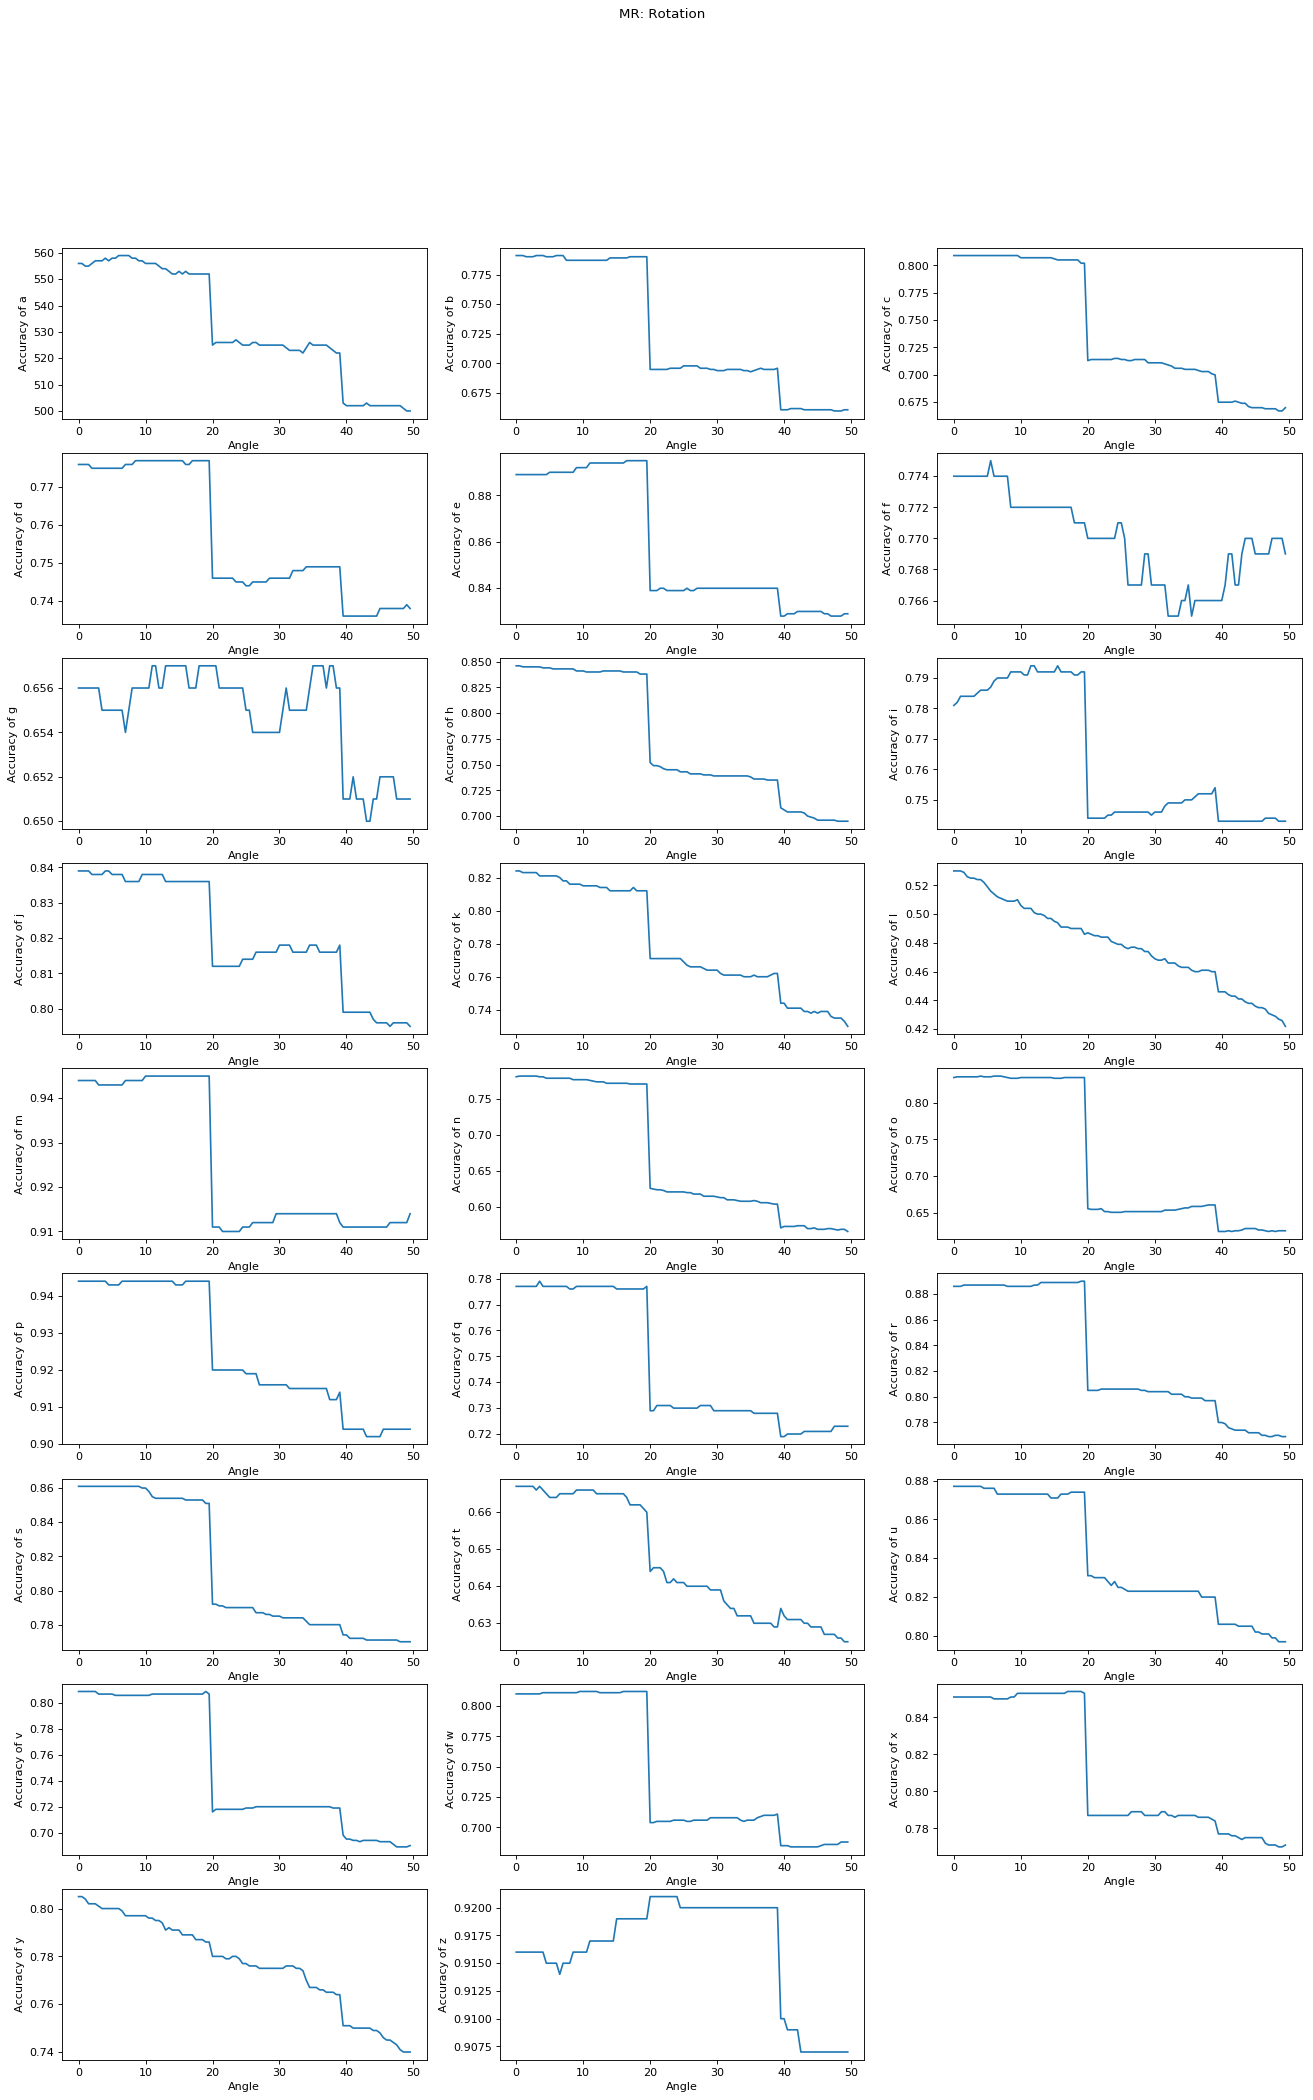

In [130]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 30), dpi=80, facecolor='w', edgecolor='k')

zero = []
for j in range(num_classes):
    zero = []
    for i in range(len(aMatrix)):
        zero.append(aMatrix[i][j][j])
    plt.subplot(9,3,j+1)
    plt.plot(np.arange(0,50,0.5),zero)
    plt.xlabel("Angle")
    plt.ylabel("Accuracy of %s" %chr(97+j))
plt.suptitle("MR: Rotation")
plt.show()

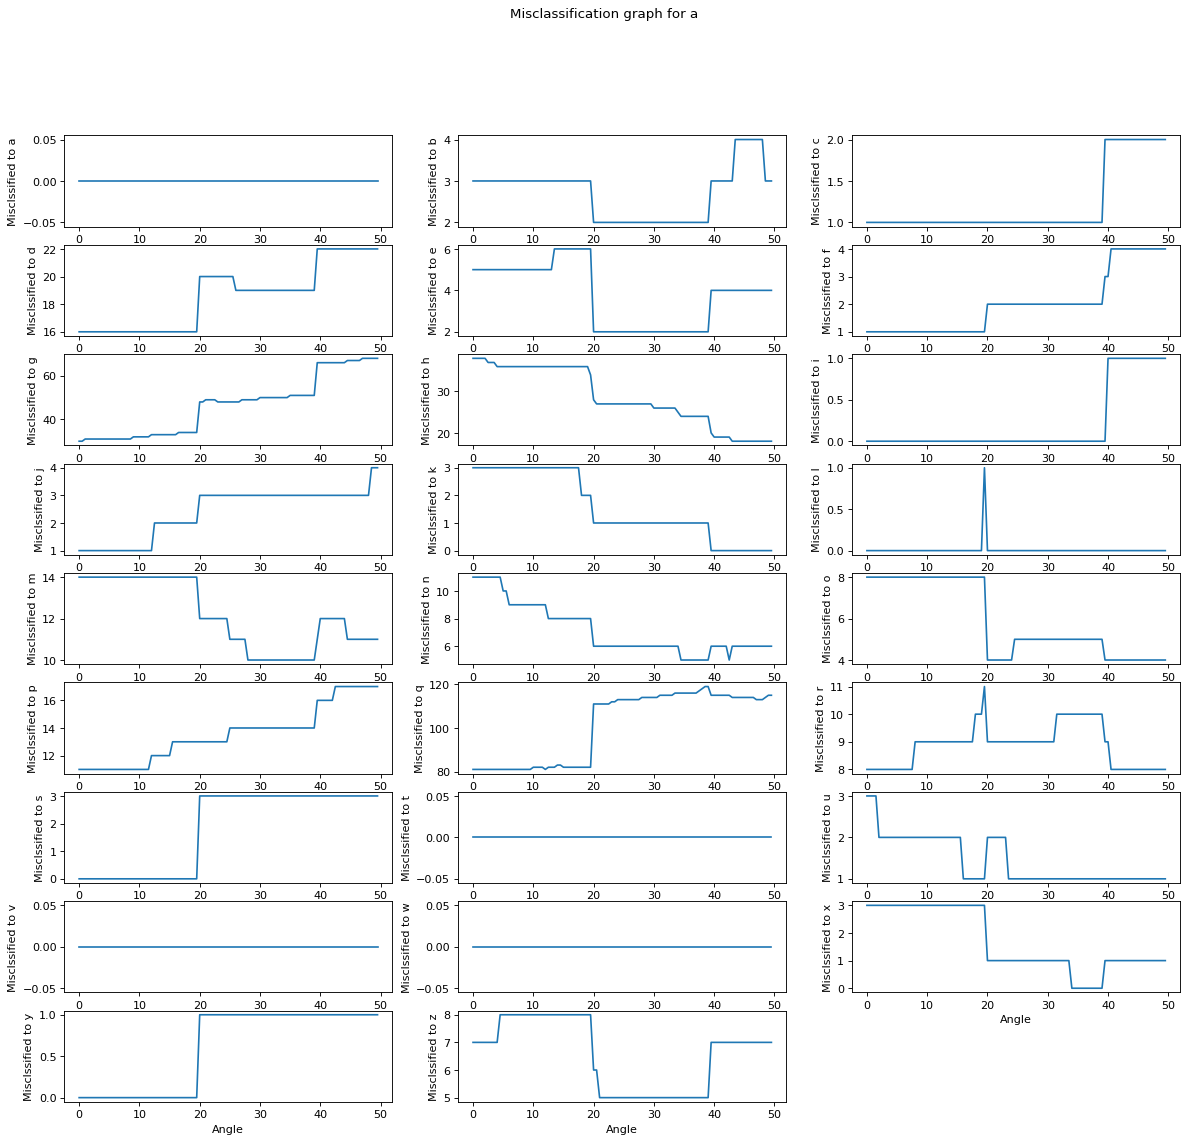

---------------------------------------------------------------------------------------------------------------------


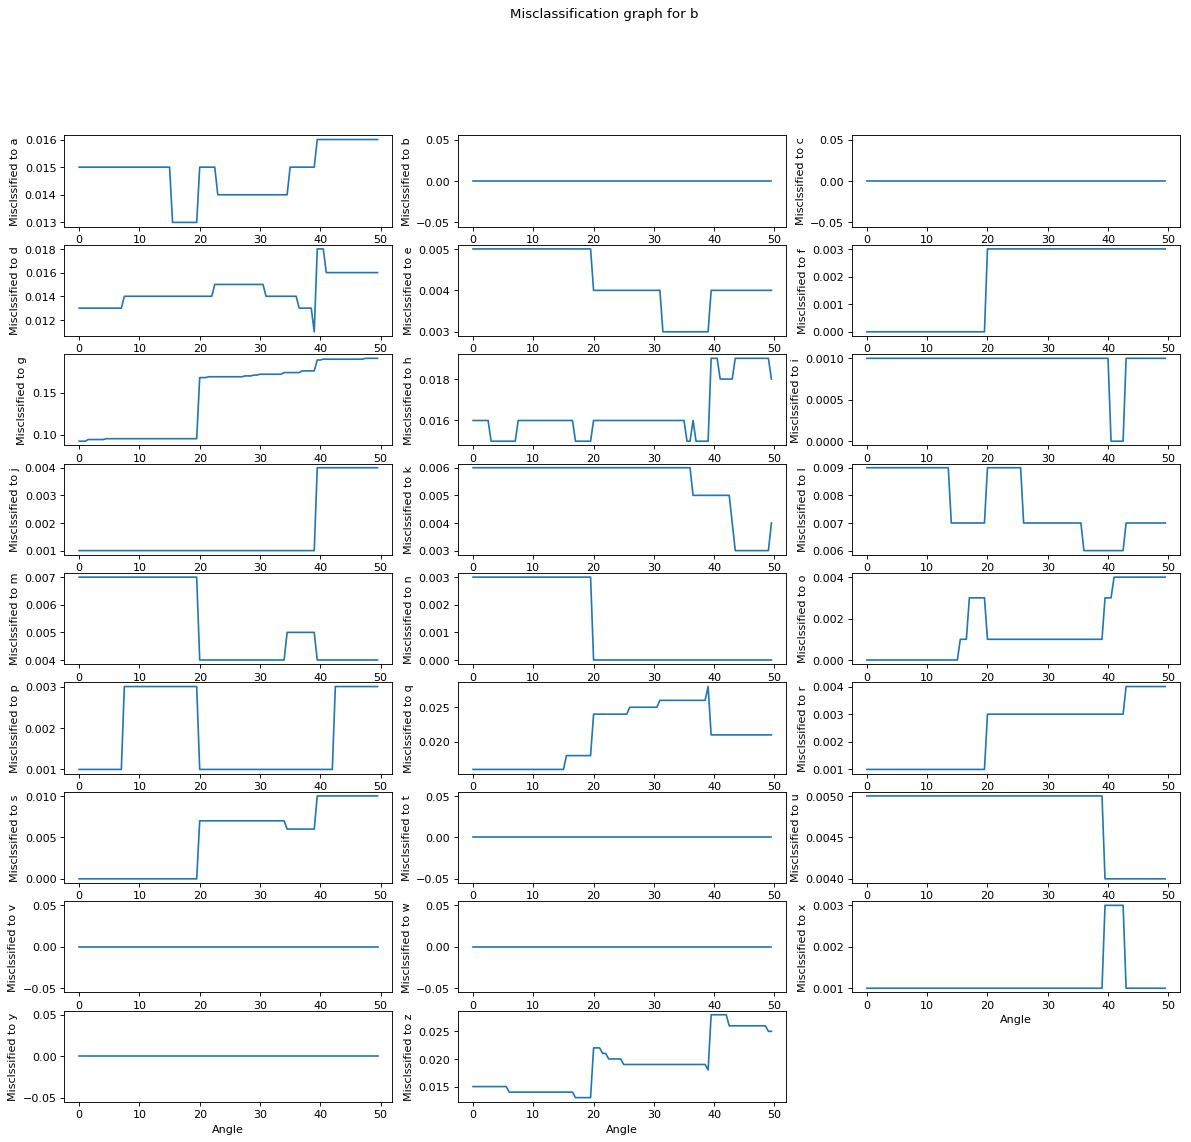

---------------------------------------------------------------------------------------------------------------------


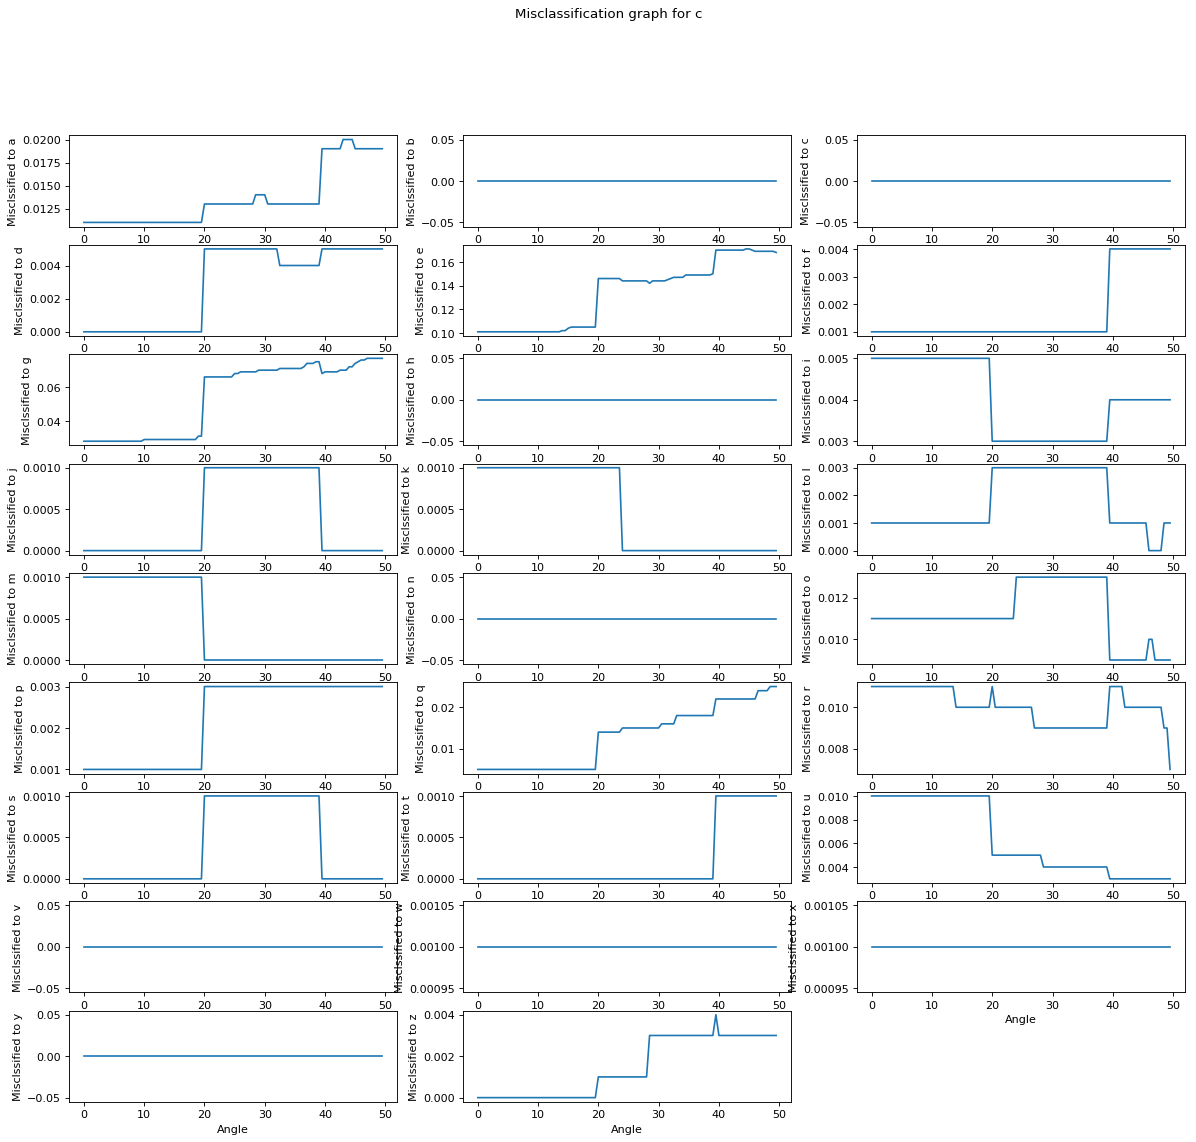

---------------------------------------------------------------------------------------------------------------------


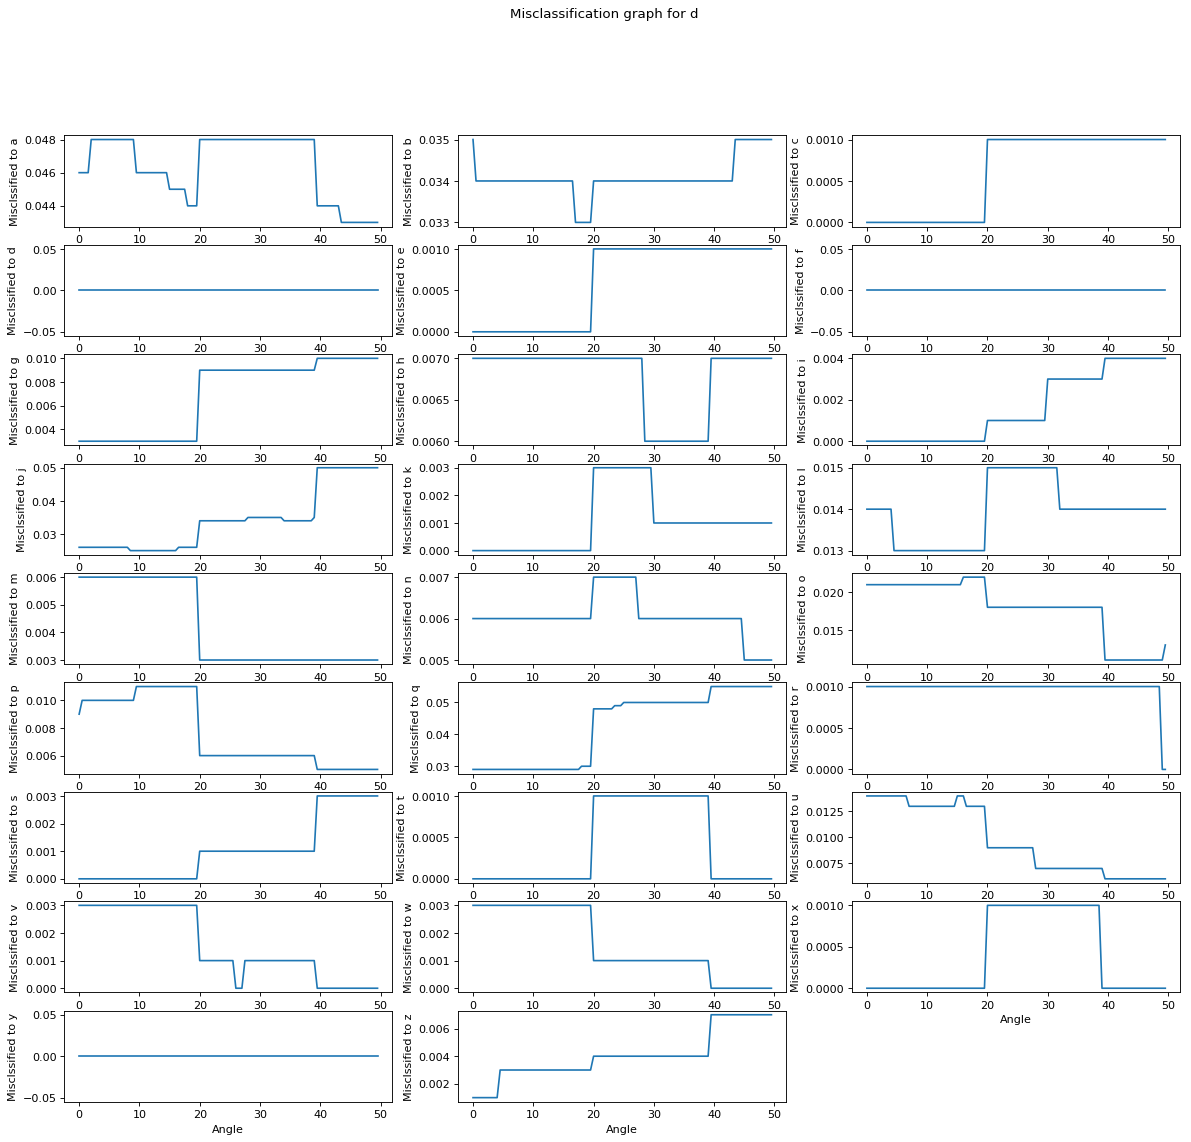

---------------------------------------------------------------------------------------------------------------------


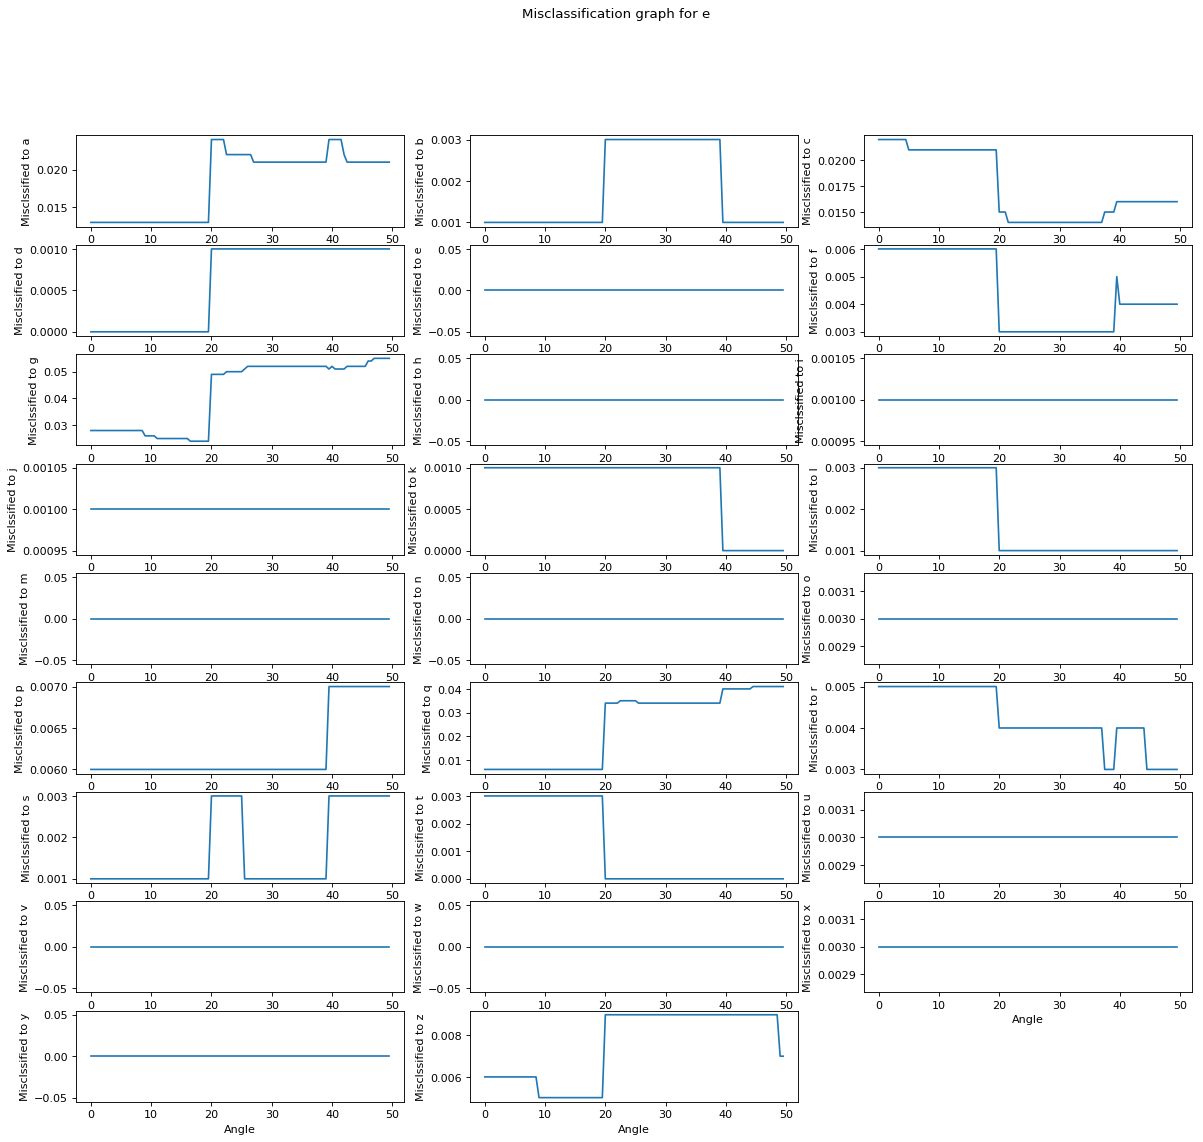

---------------------------------------------------------------------------------------------------------------------


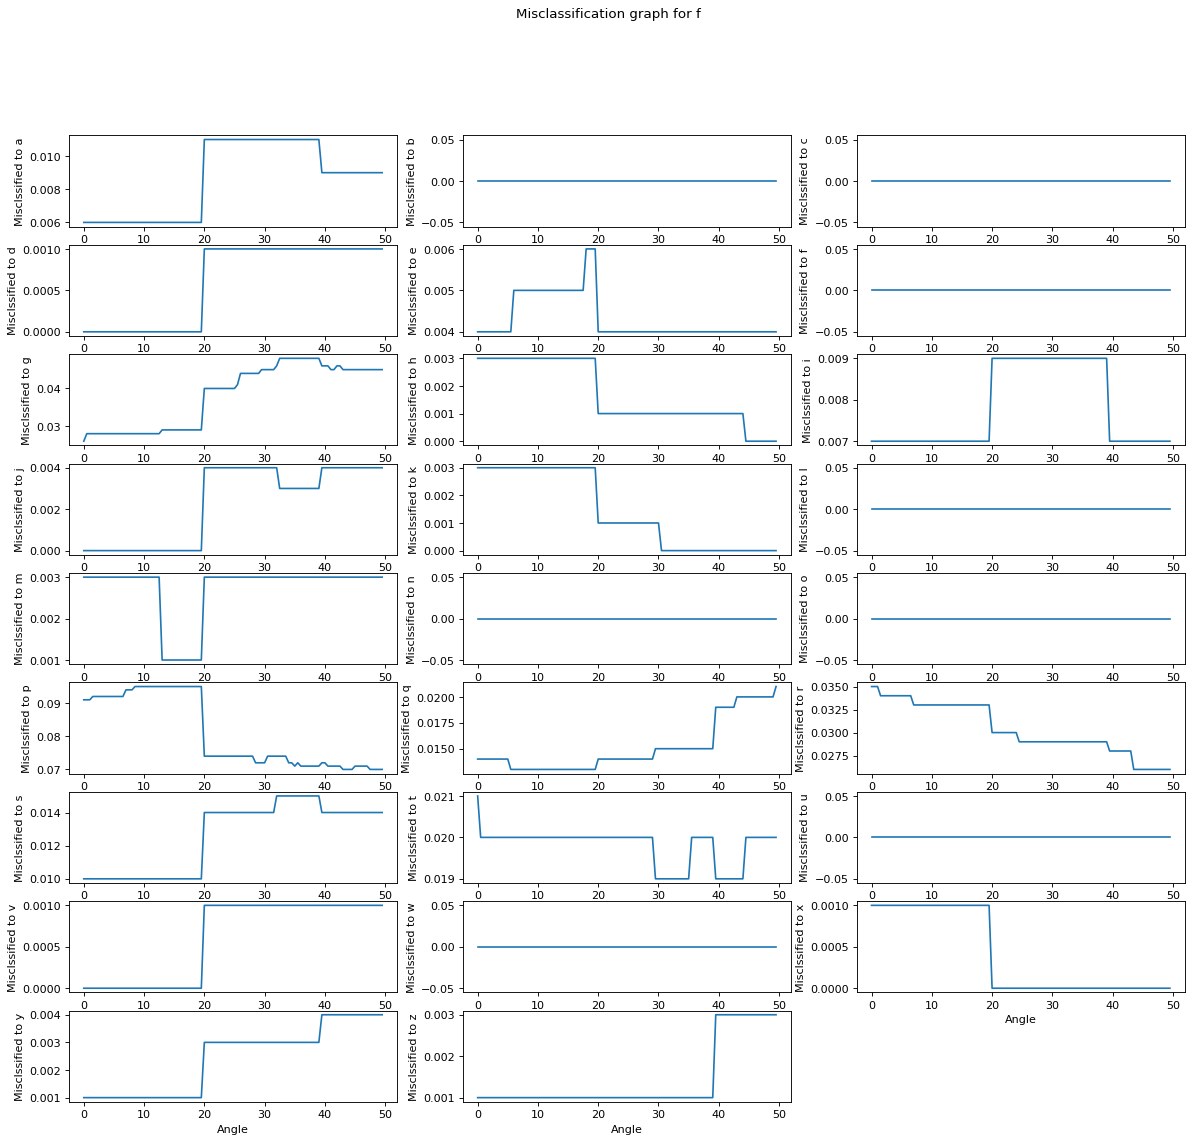

---------------------------------------------------------------------------------------------------------------------


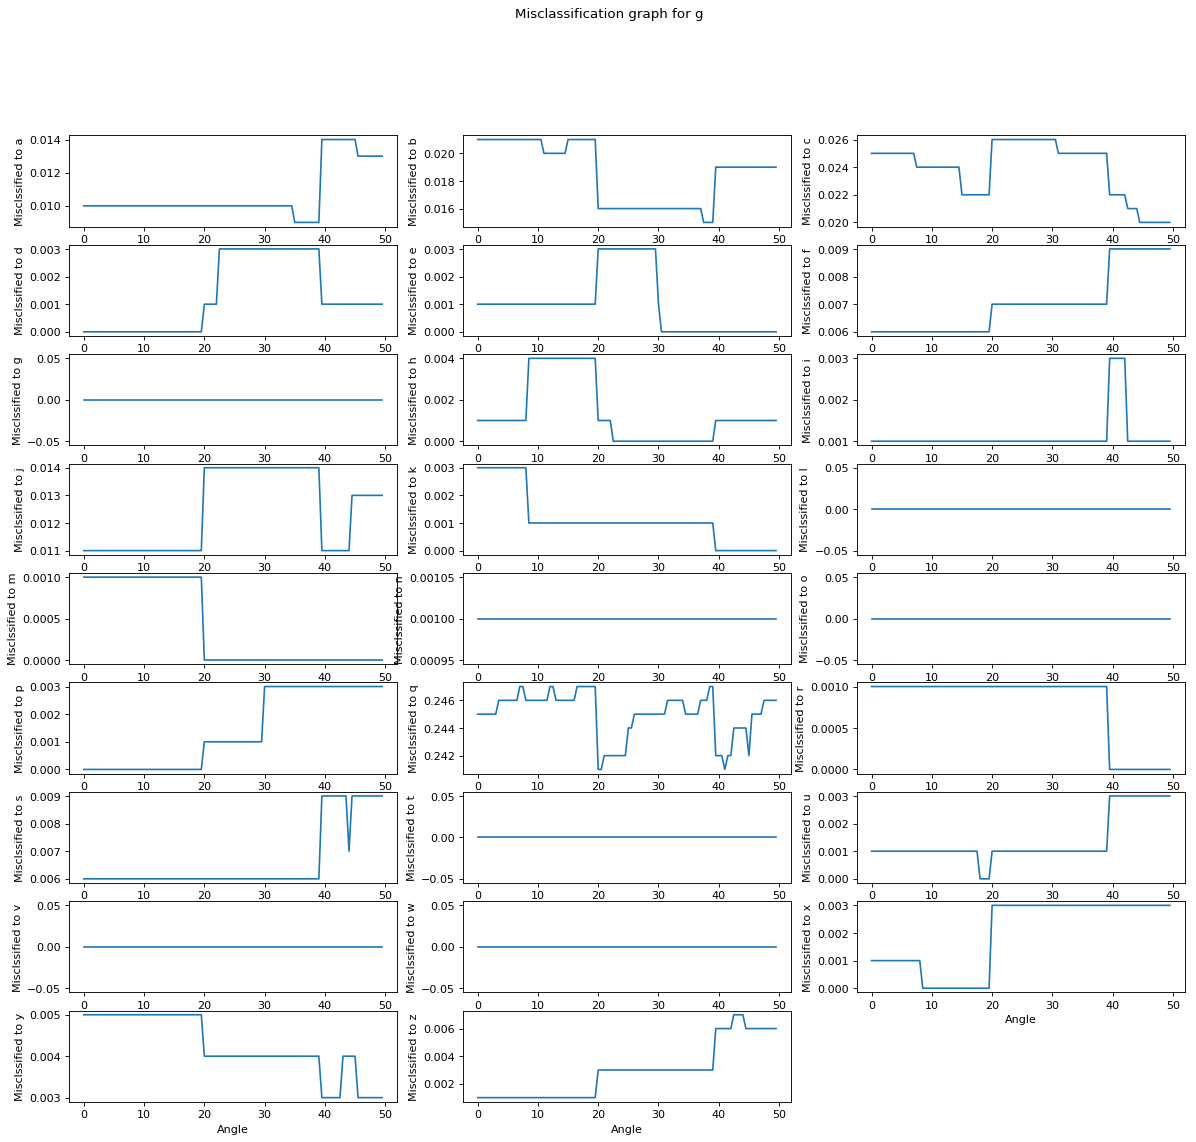

---------------------------------------------------------------------------------------------------------------------


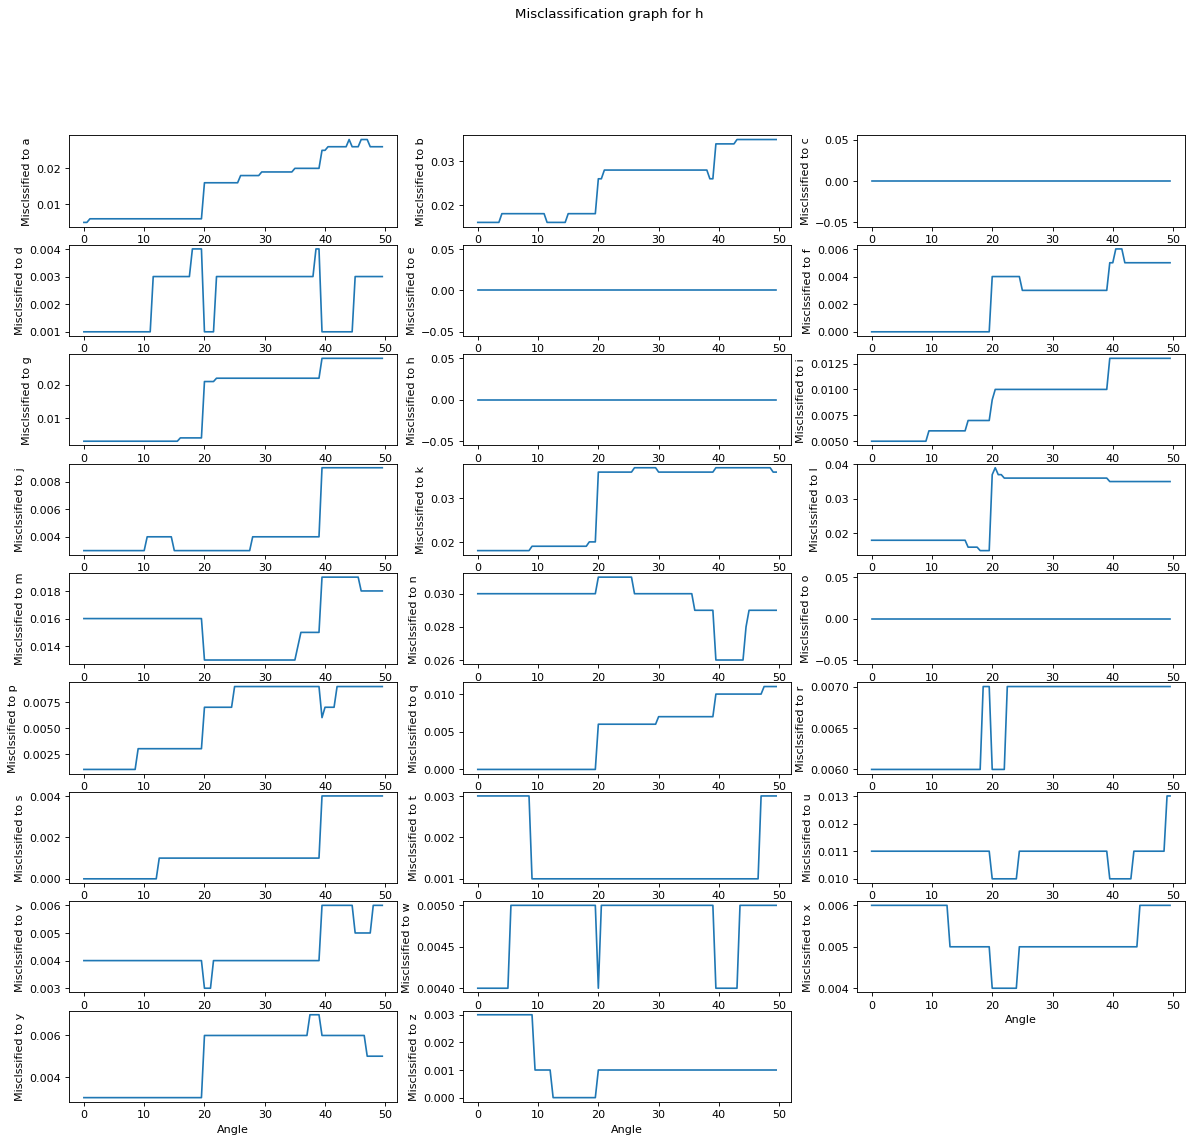

---------------------------------------------------------------------------------------------------------------------


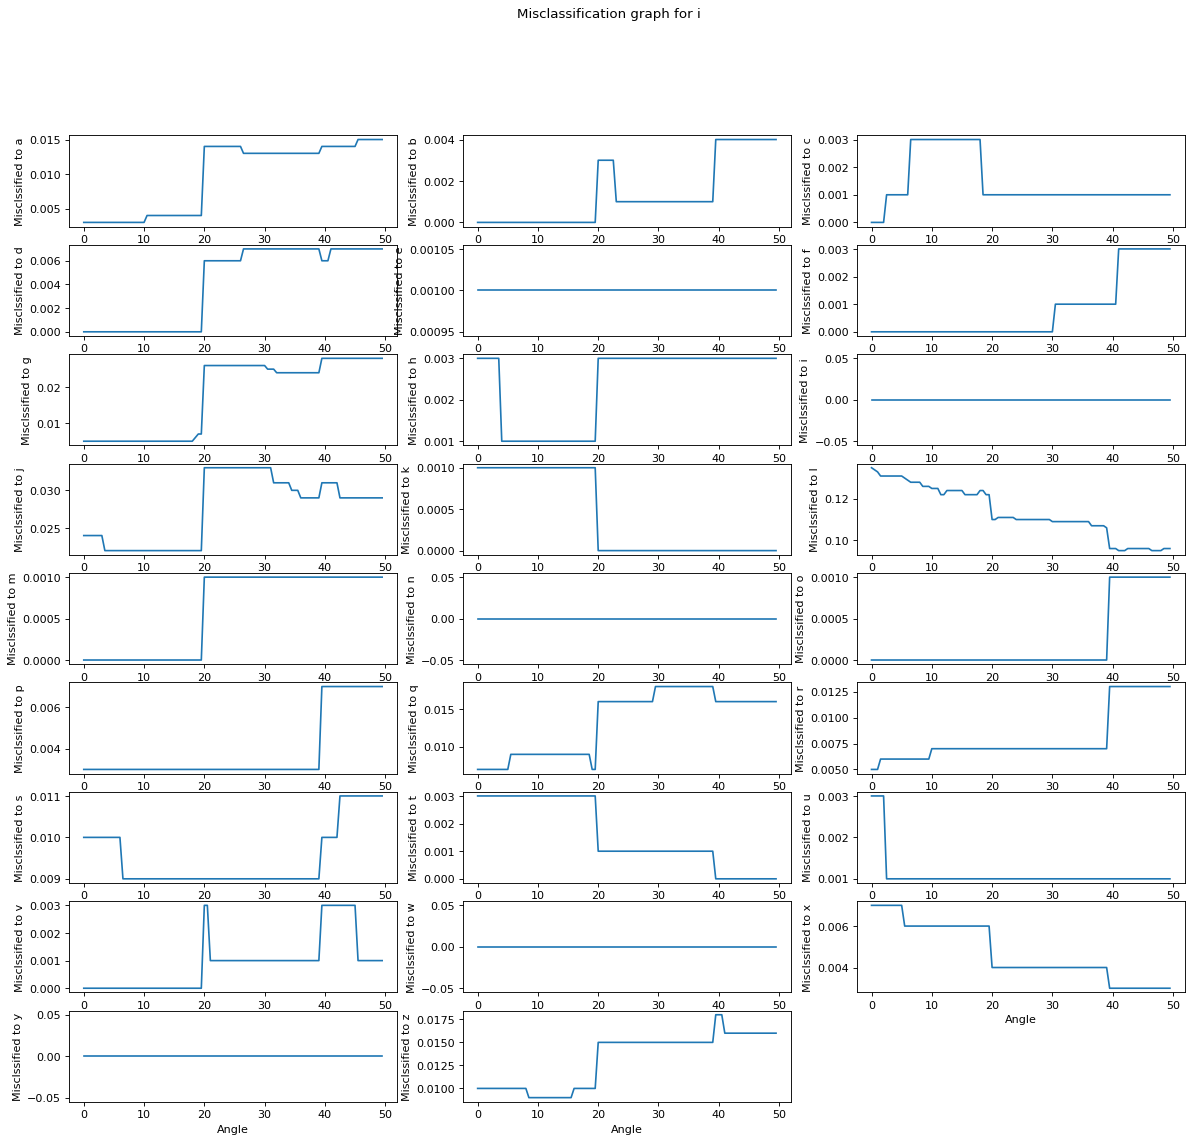

---------------------------------------------------------------------------------------------------------------------


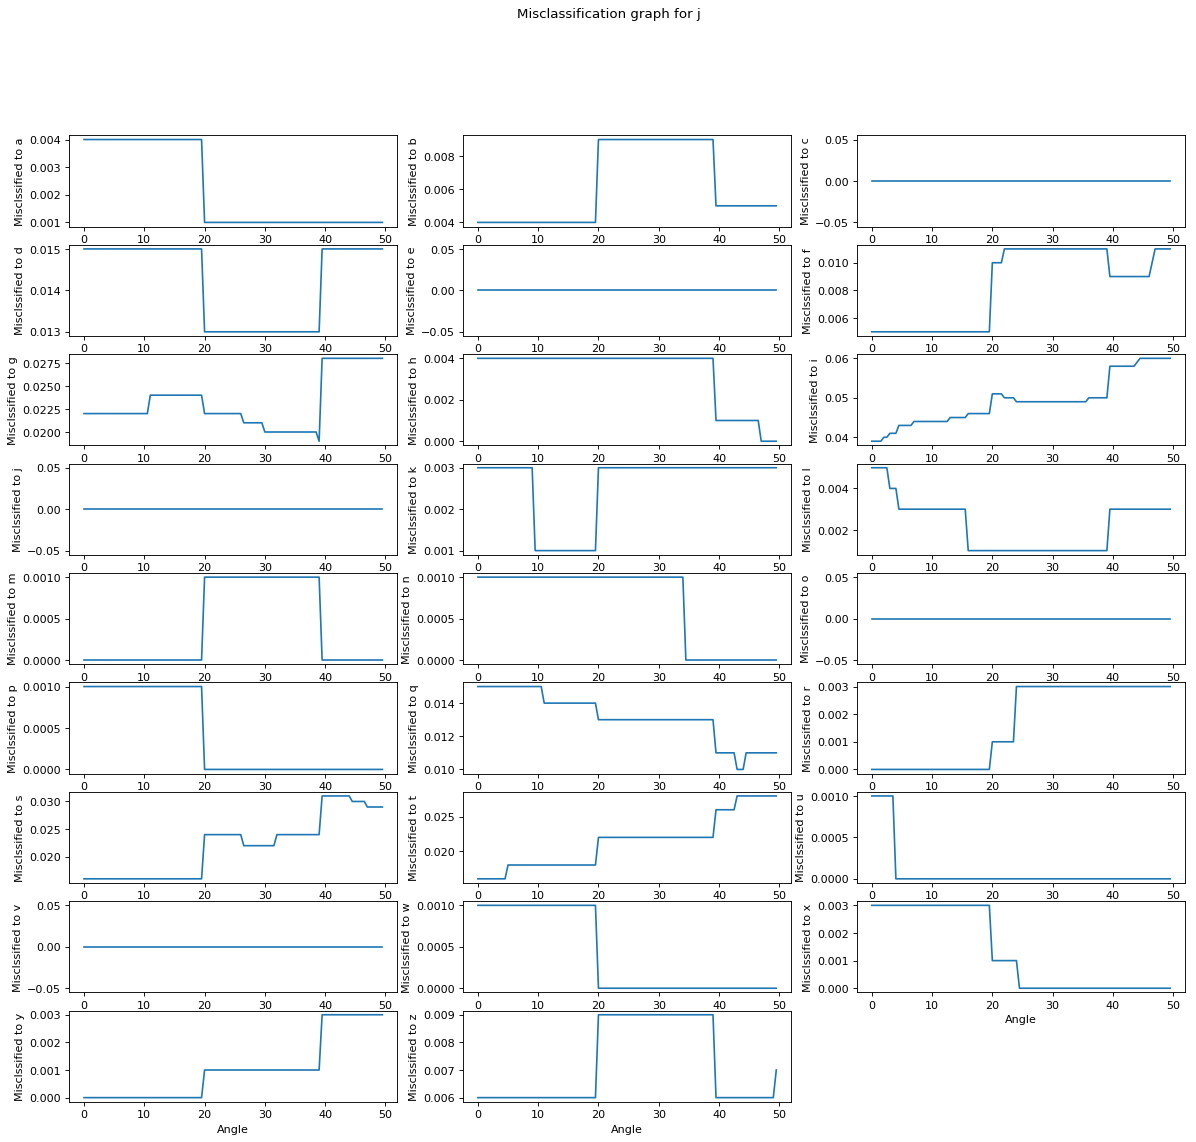

---------------------------------------------------------------------------------------------------------------------


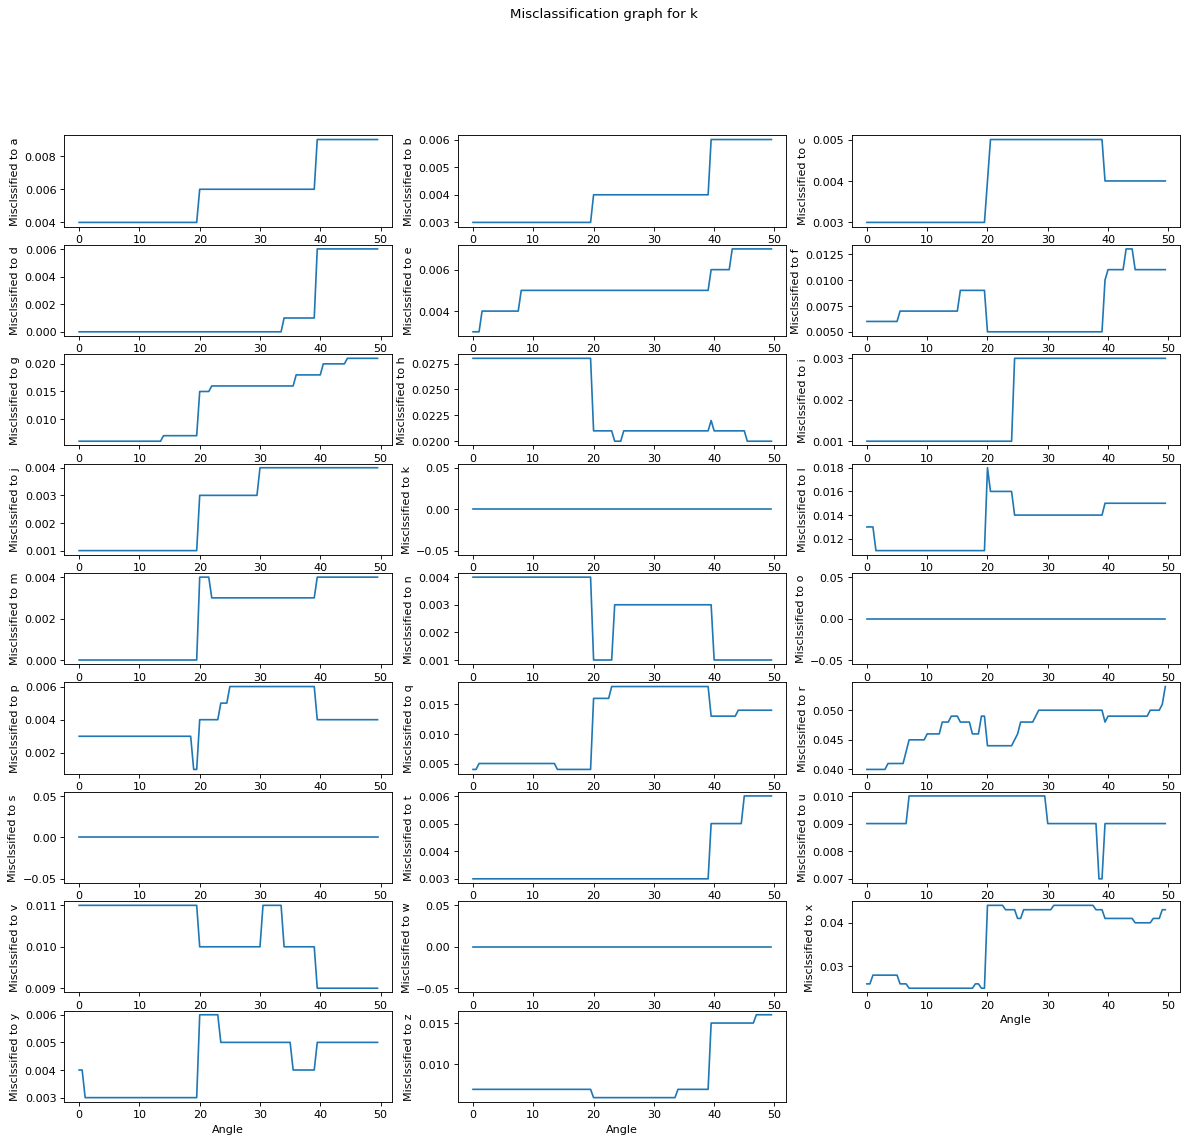

---------------------------------------------------------------------------------------------------------------------


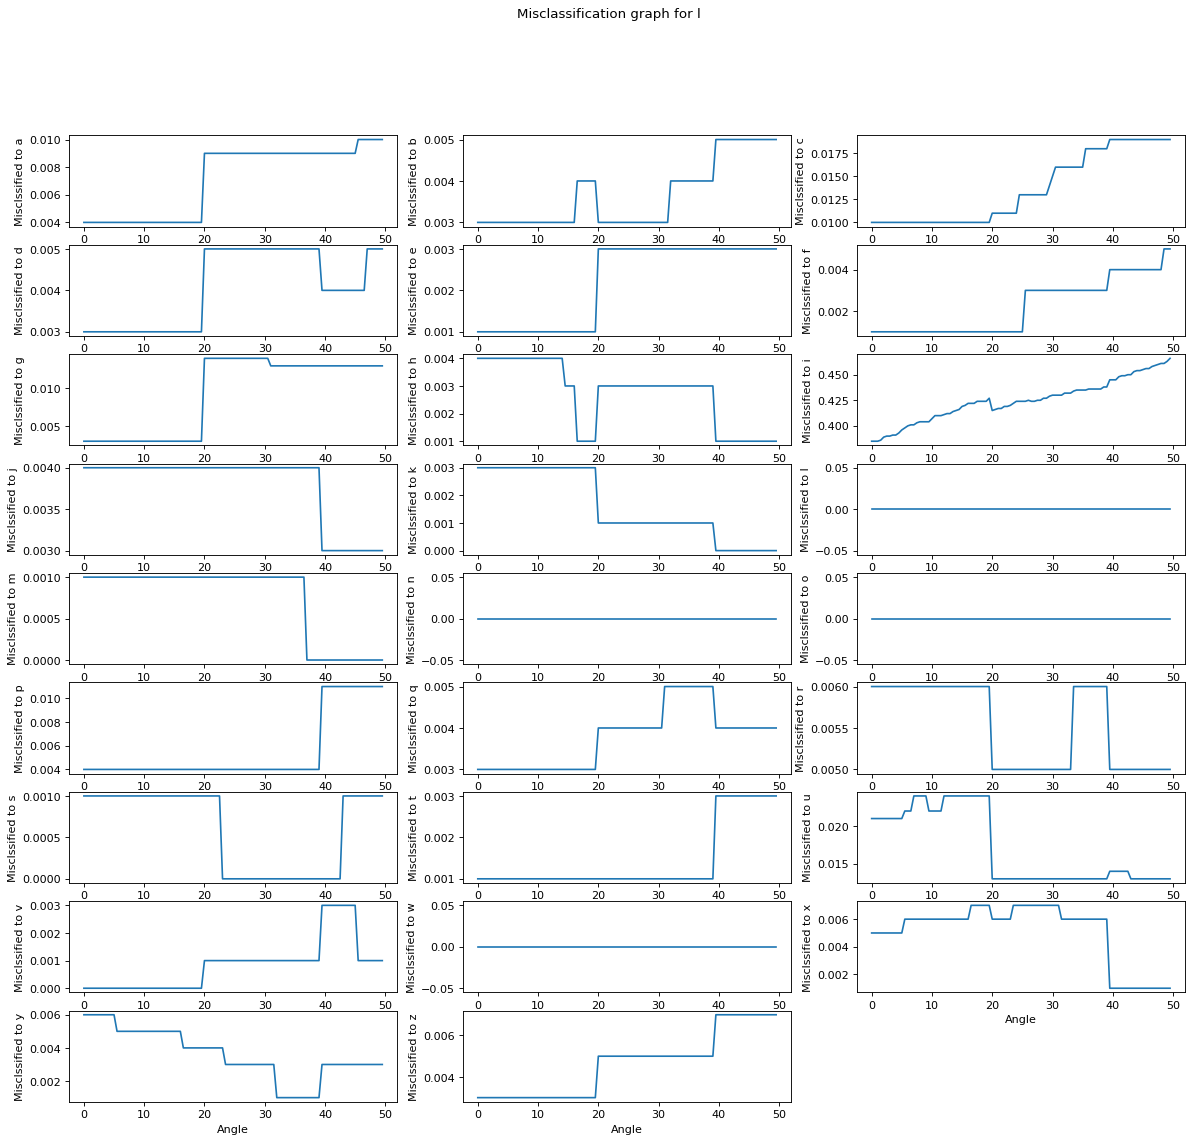

---------------------------------------------------------------------------------------------------------------------


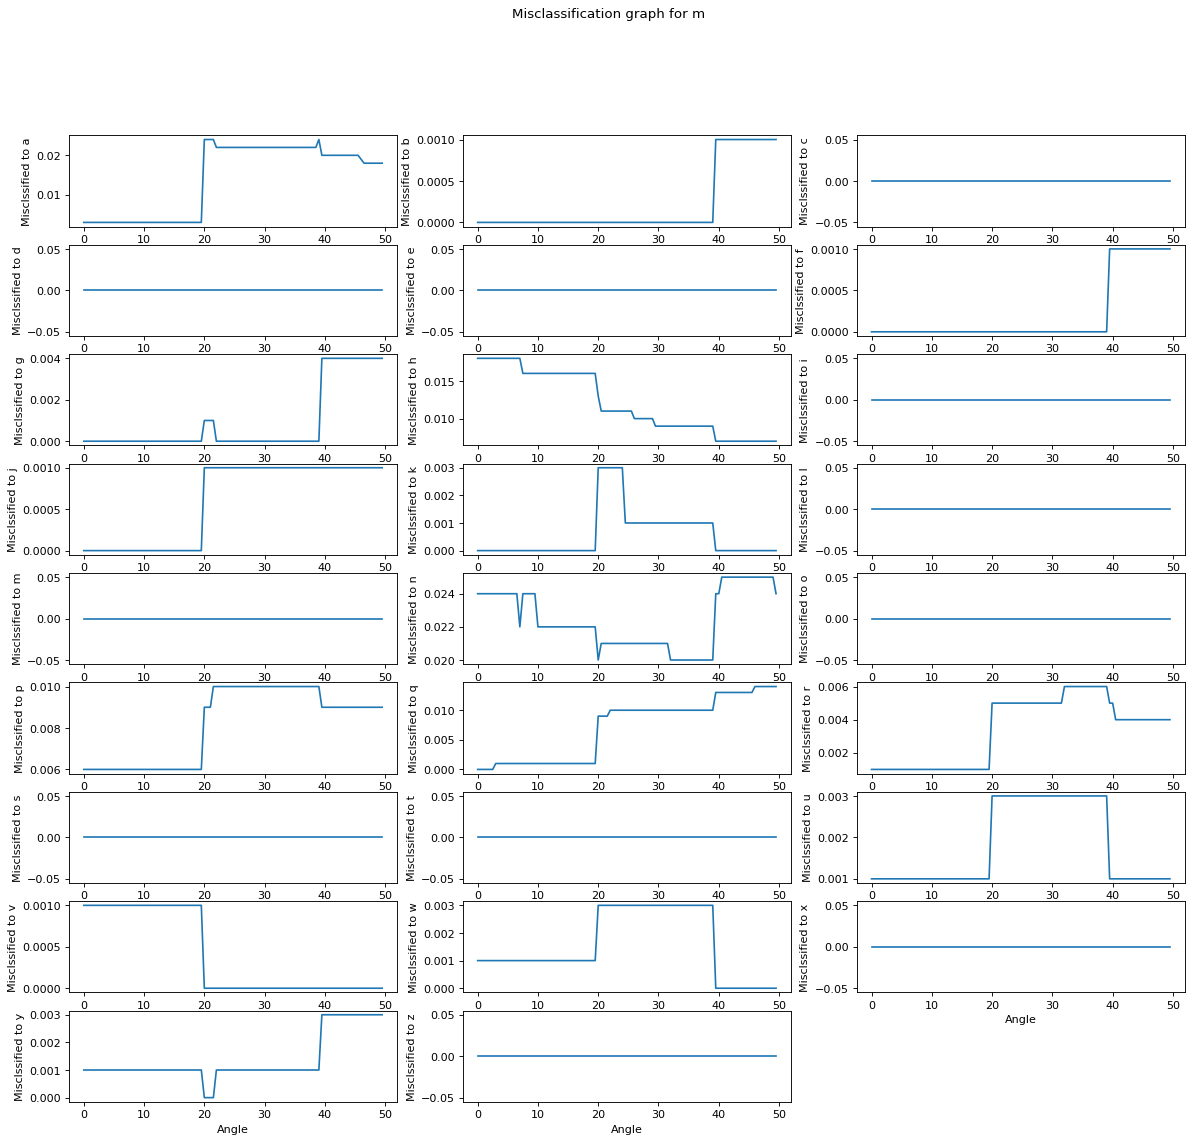

---------------------------------------------------------------------------------------------------------------------


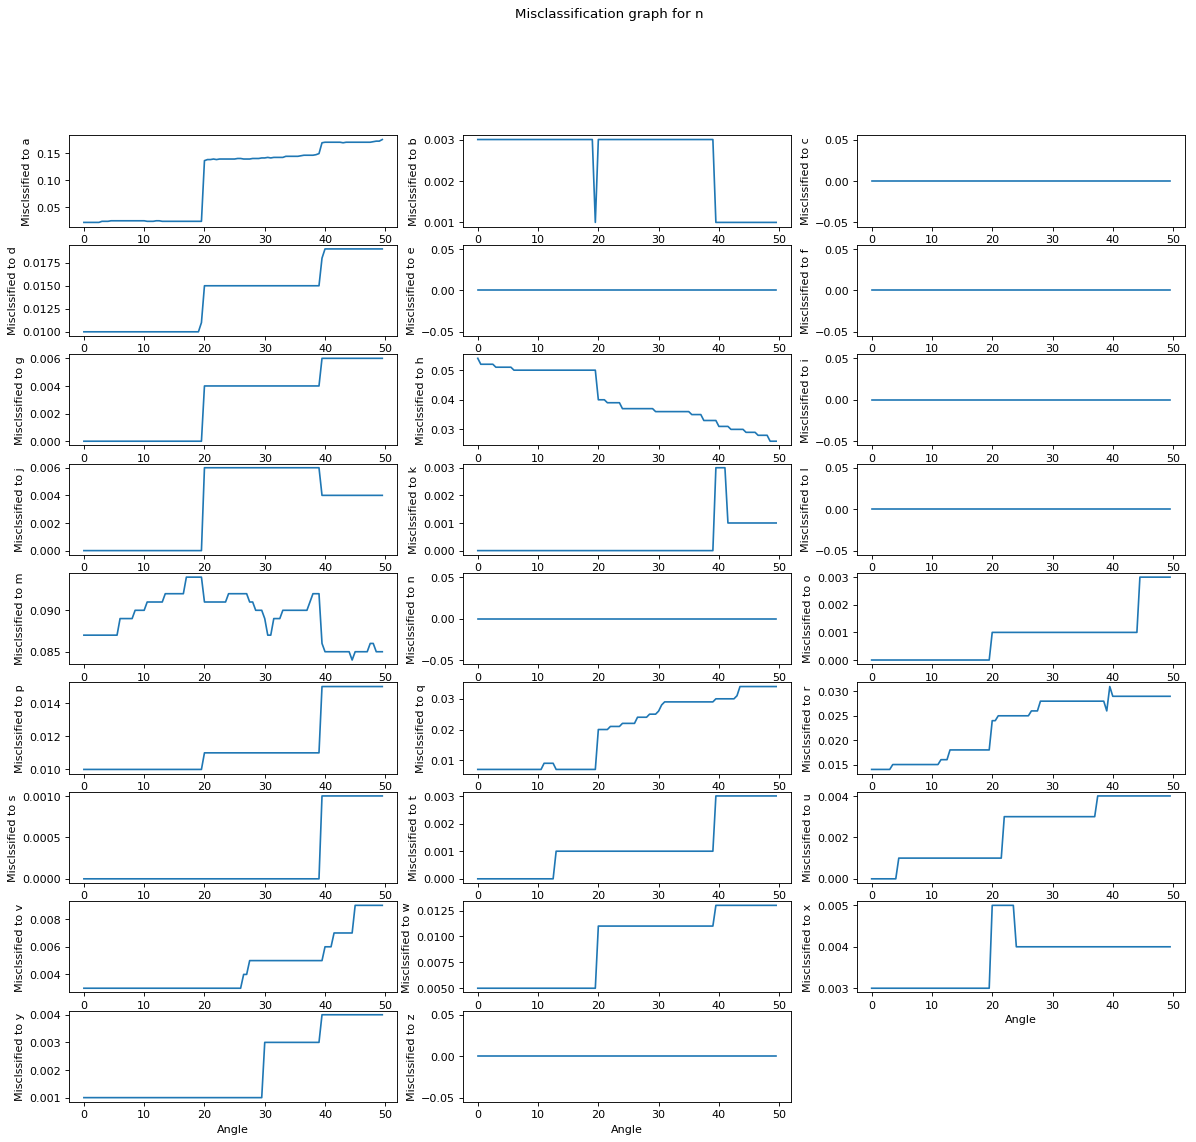

---------------------------------------------------------------------------------------------------------------------


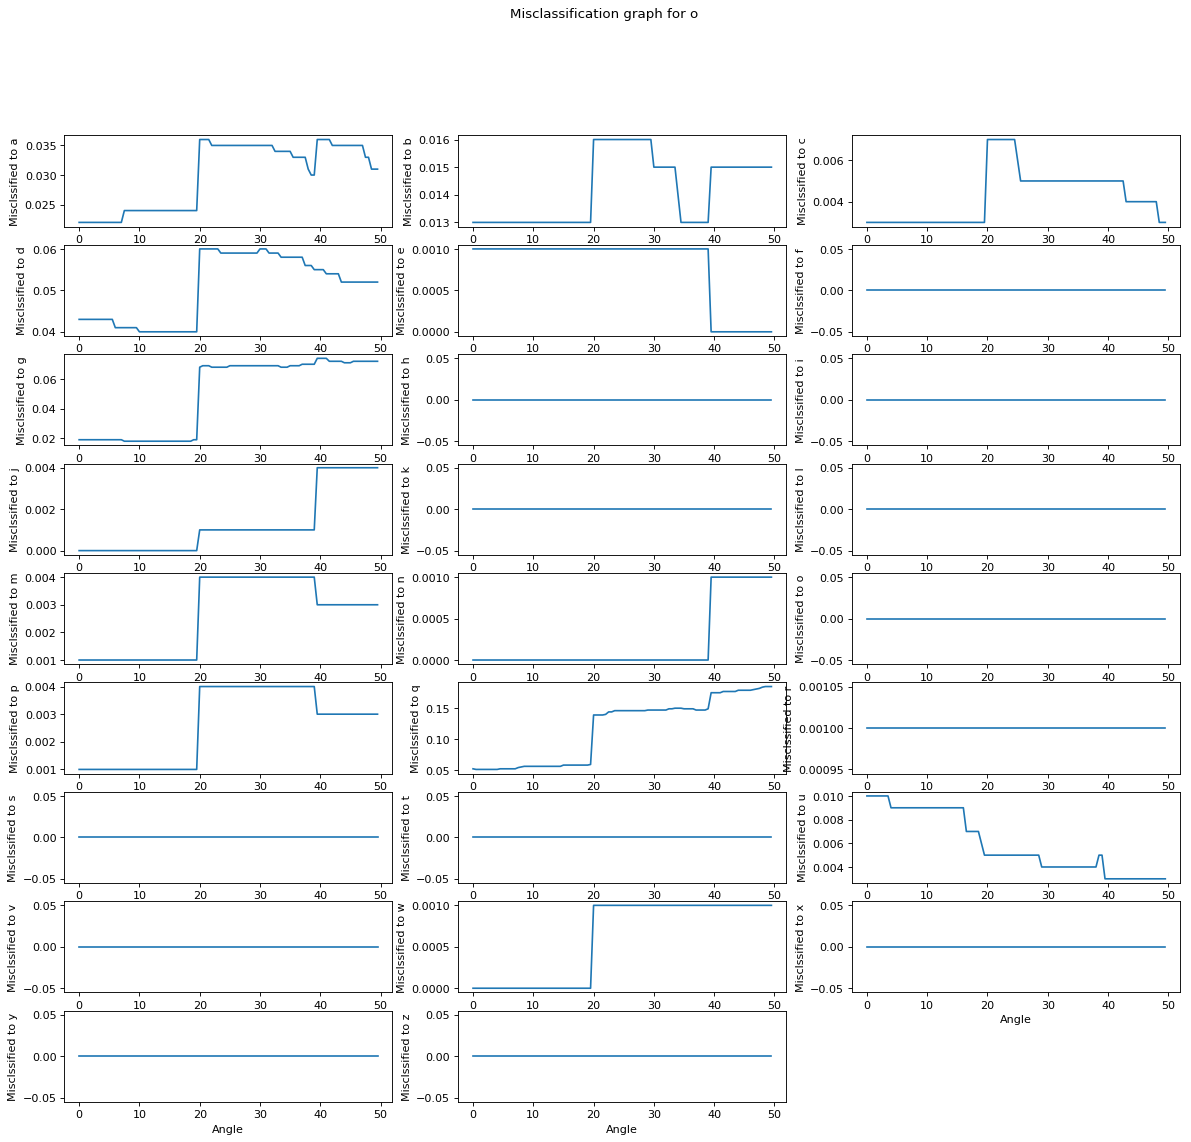

---------------------------------------------------------------------------------------------------------------------


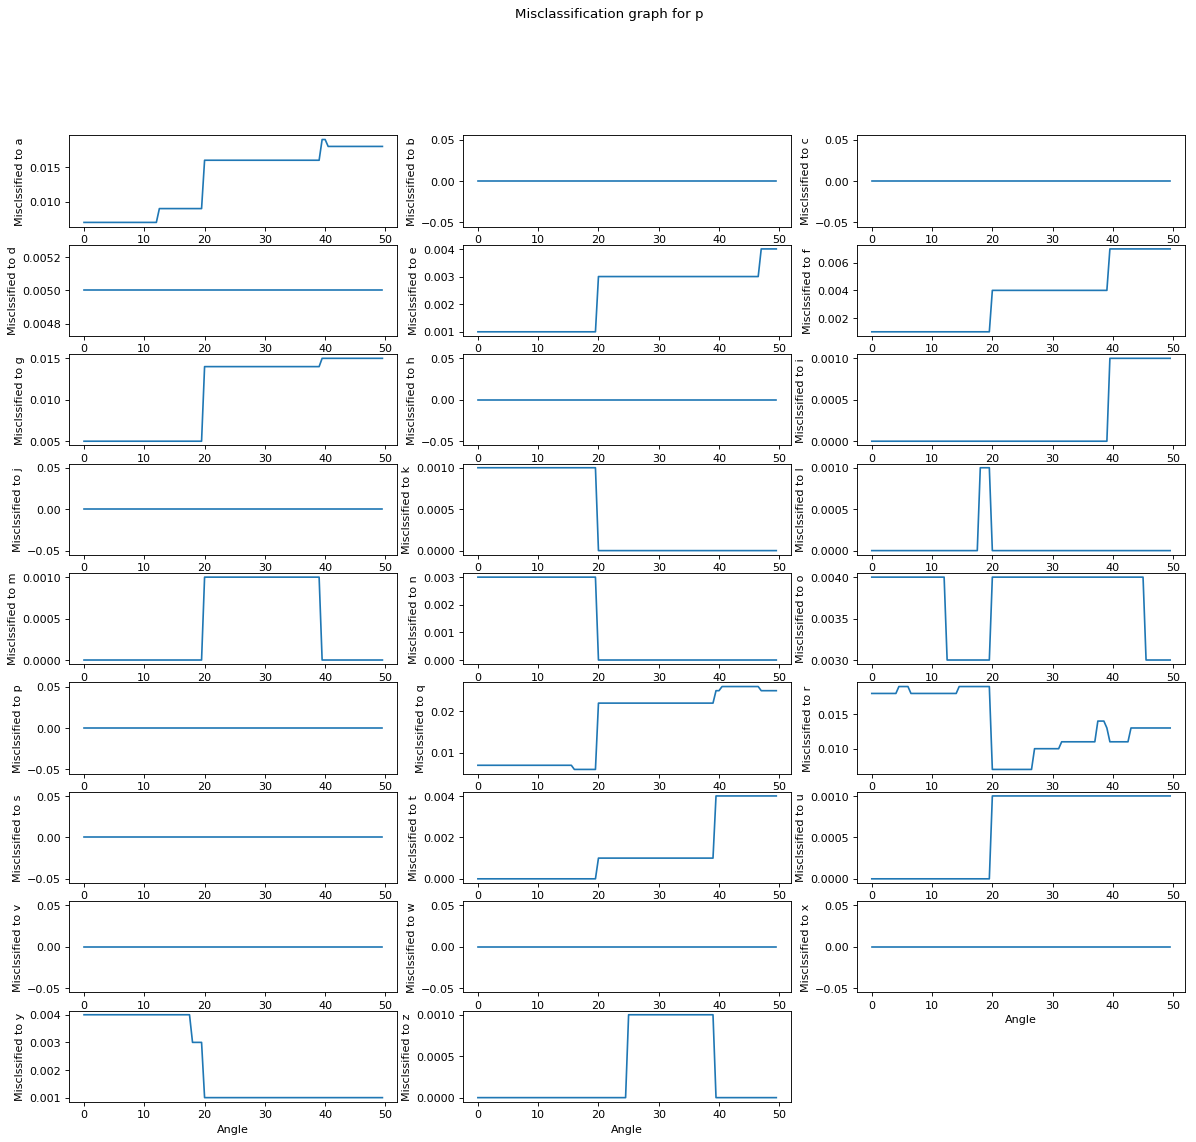

---------------------------------------------------------------------------------------------------------------------


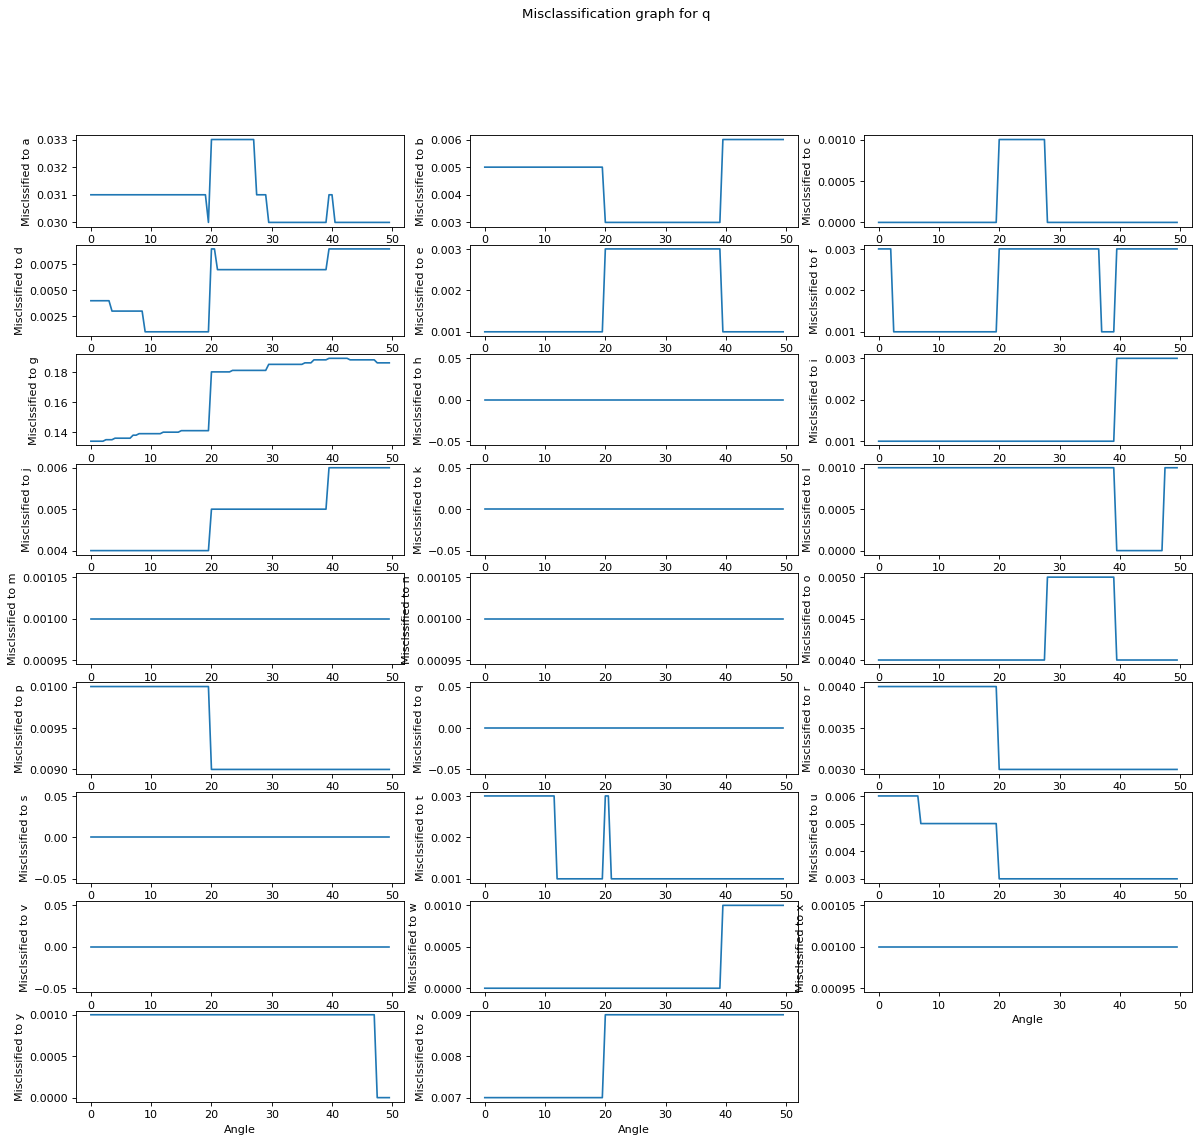

---------------------------------------------------------------------------------------------------------------------


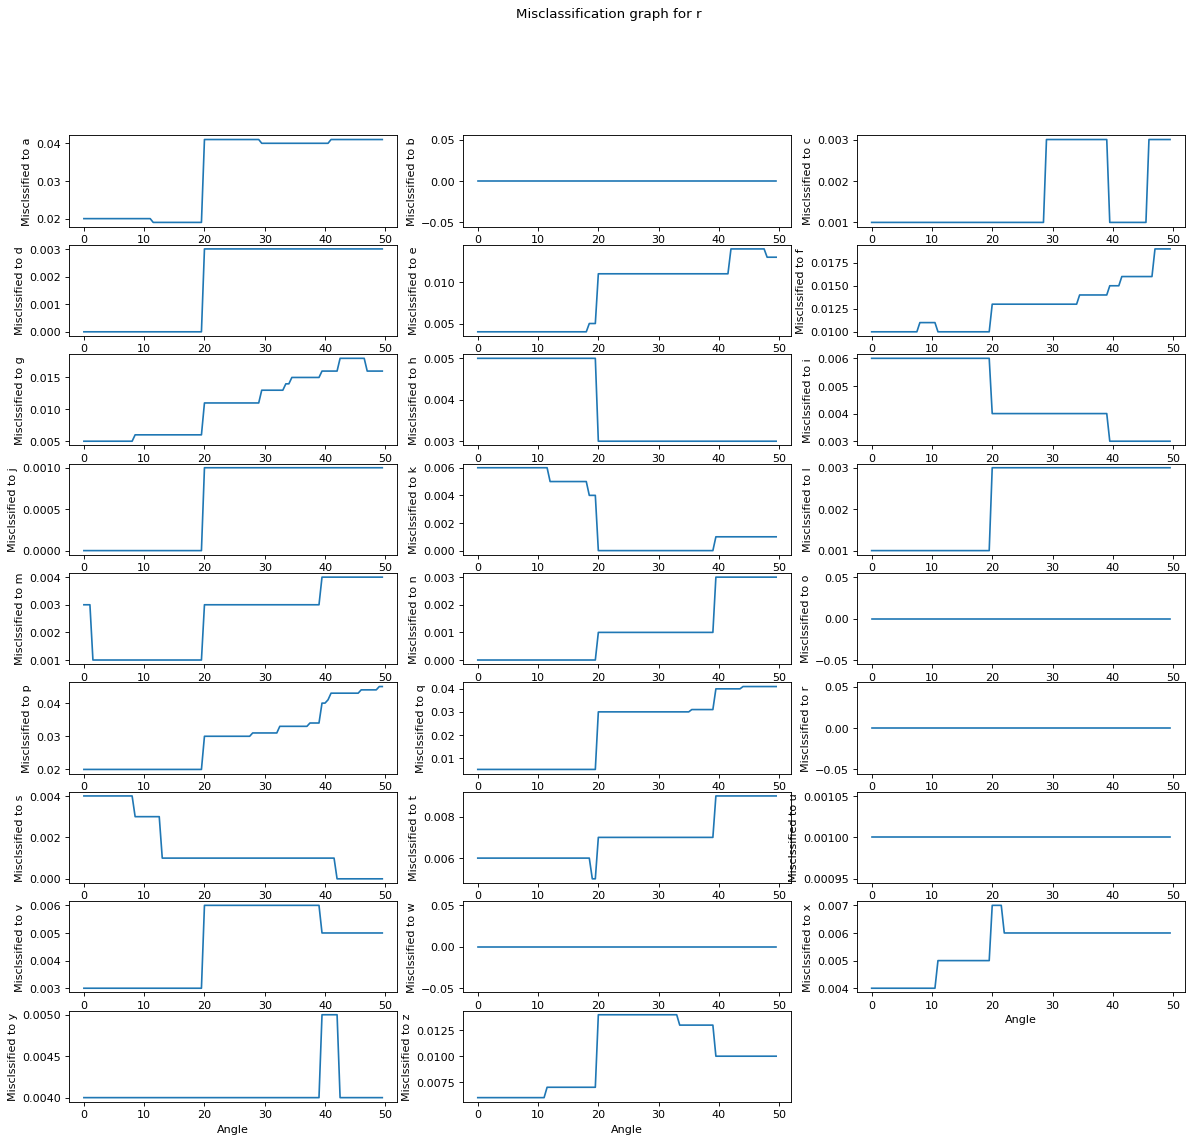

---------------------------------------------------------------------------------------------------------------------


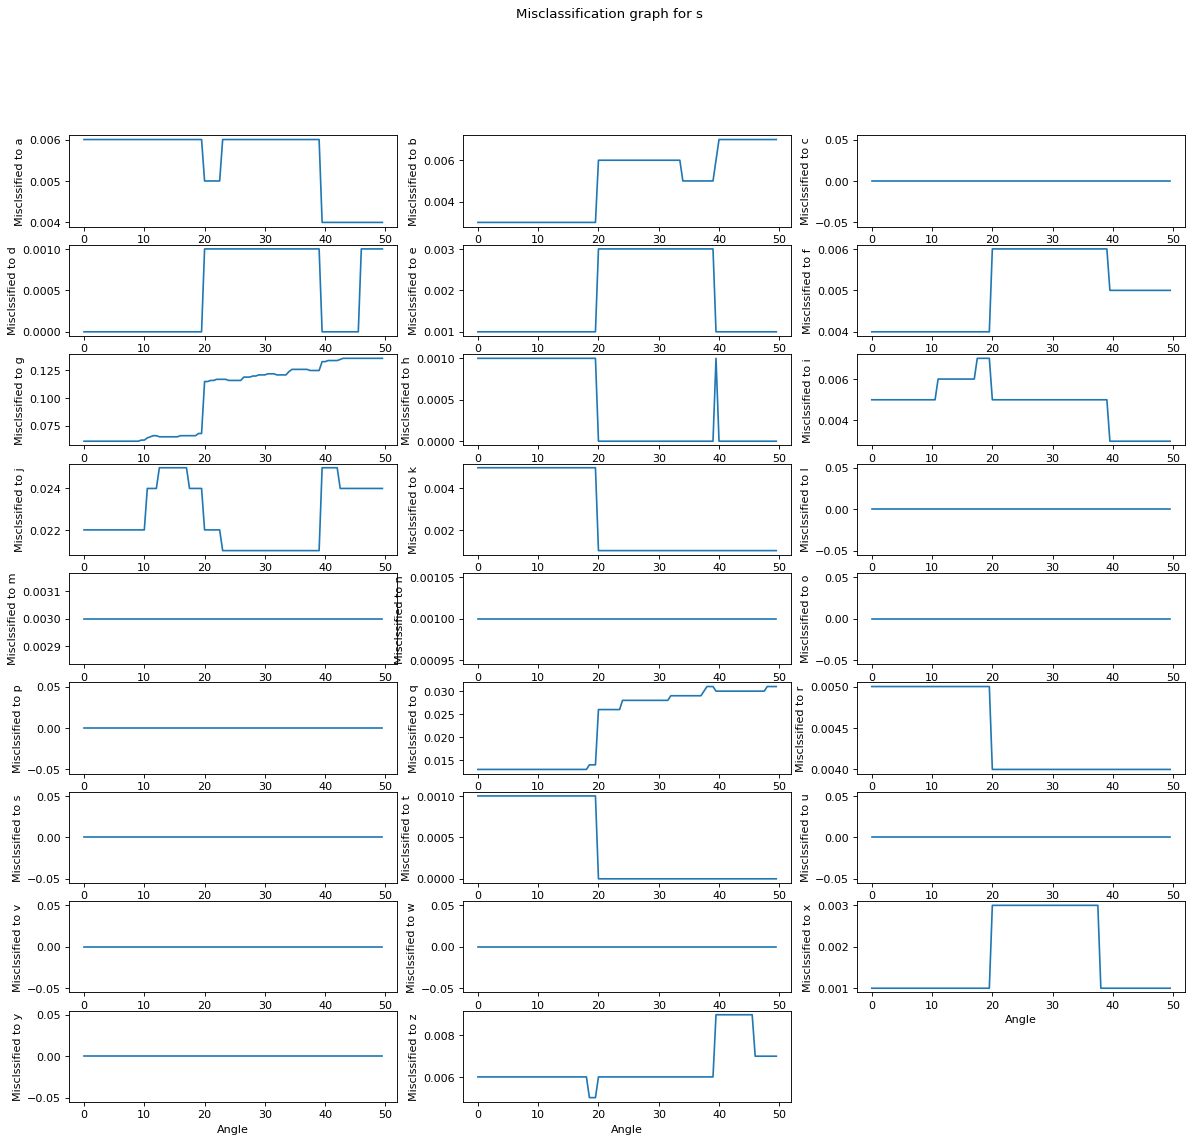

---------------------------------------------------------------------------------------------------------------------


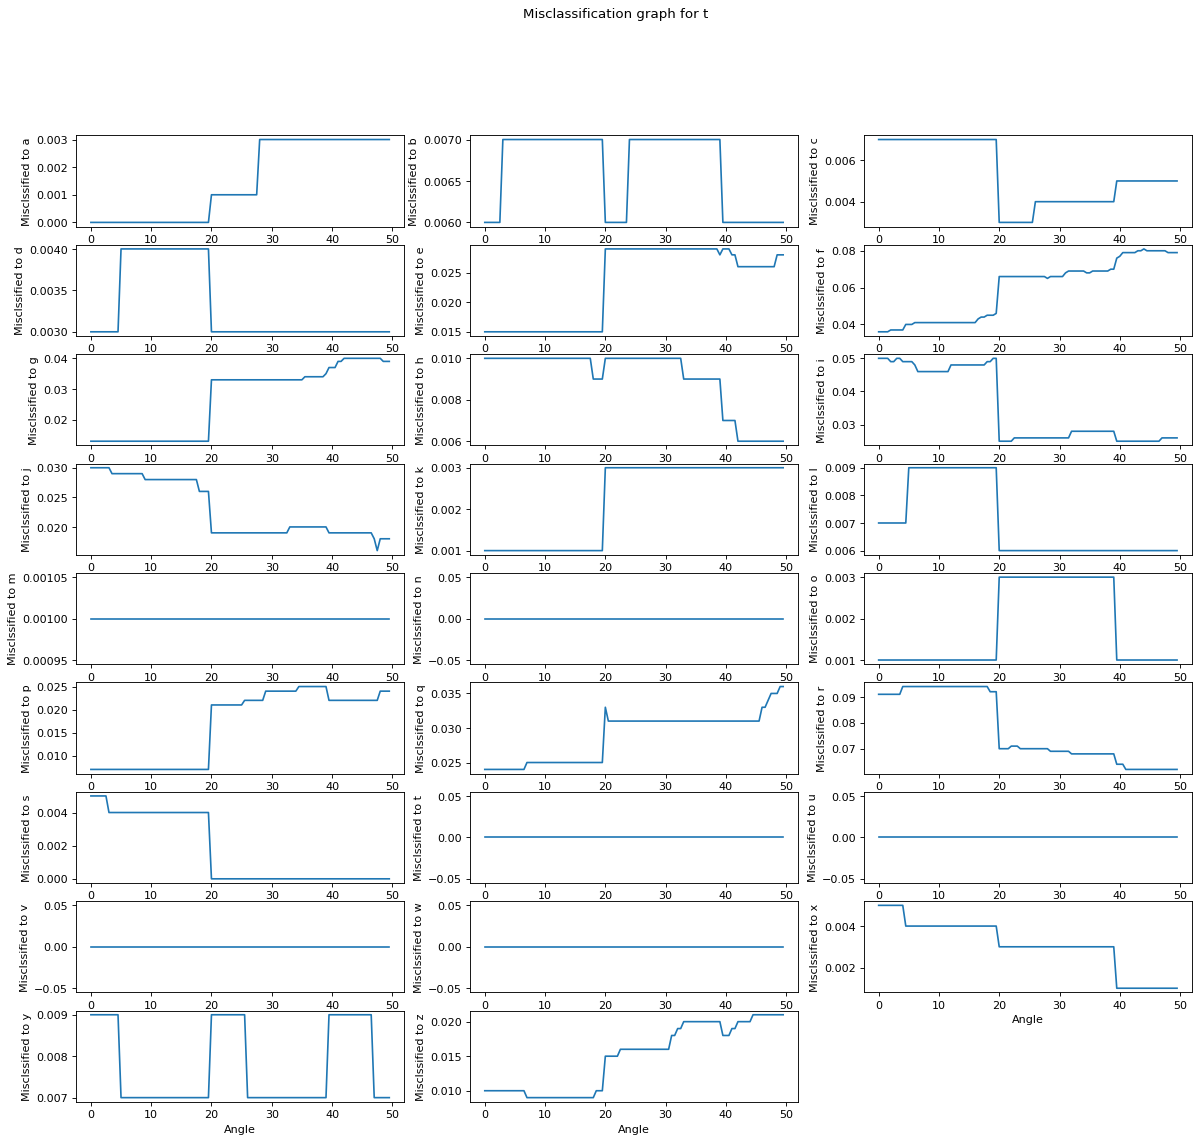

---------------------------------------------------------------------------------------------------------------------


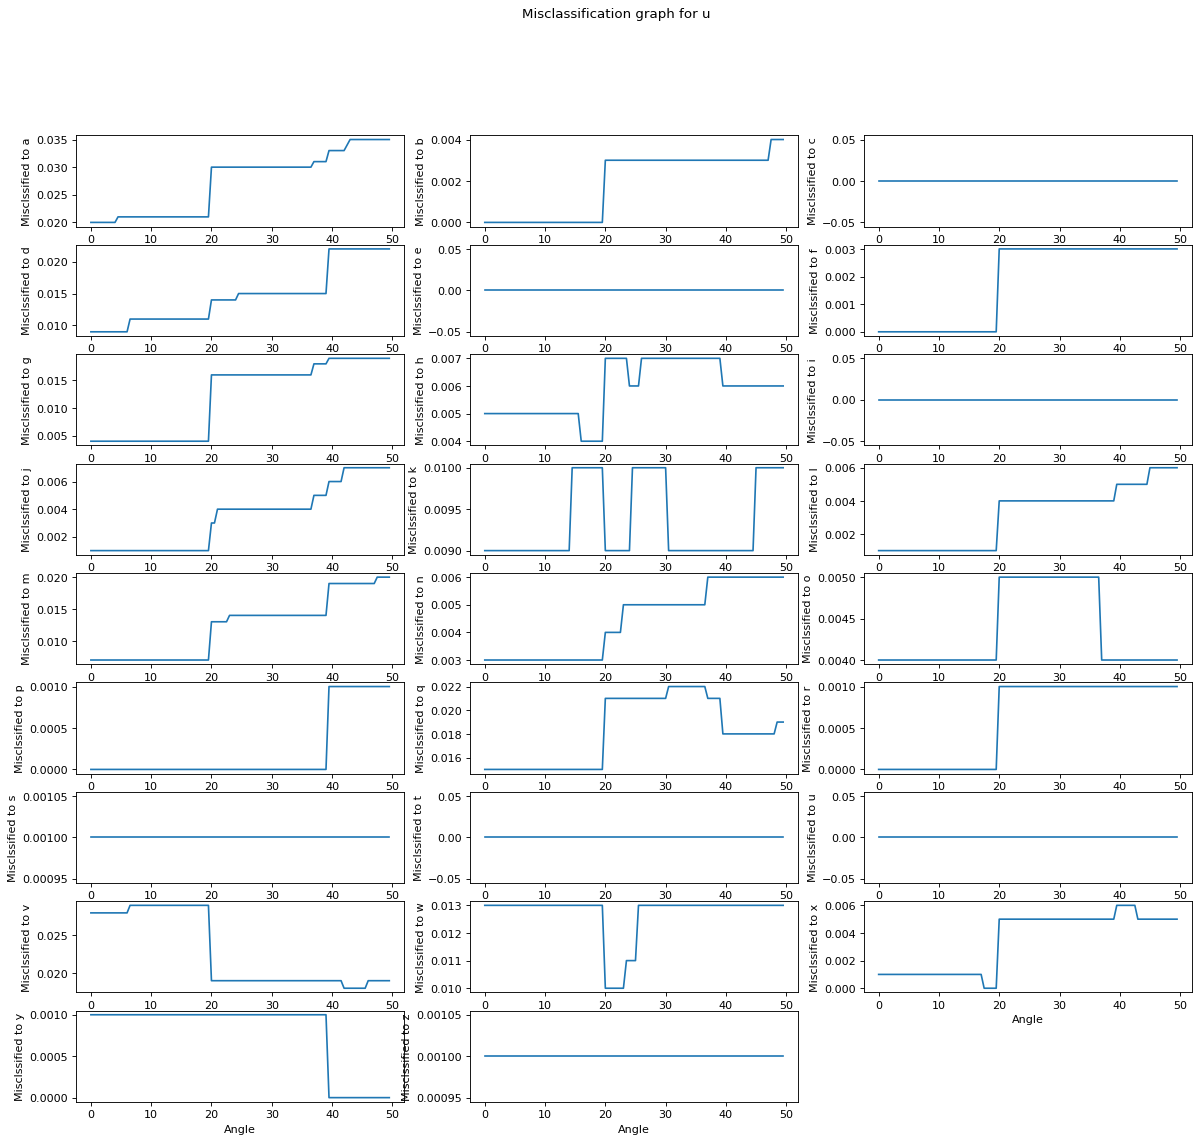

---------------------------------------------------------------------------------------------------------------------


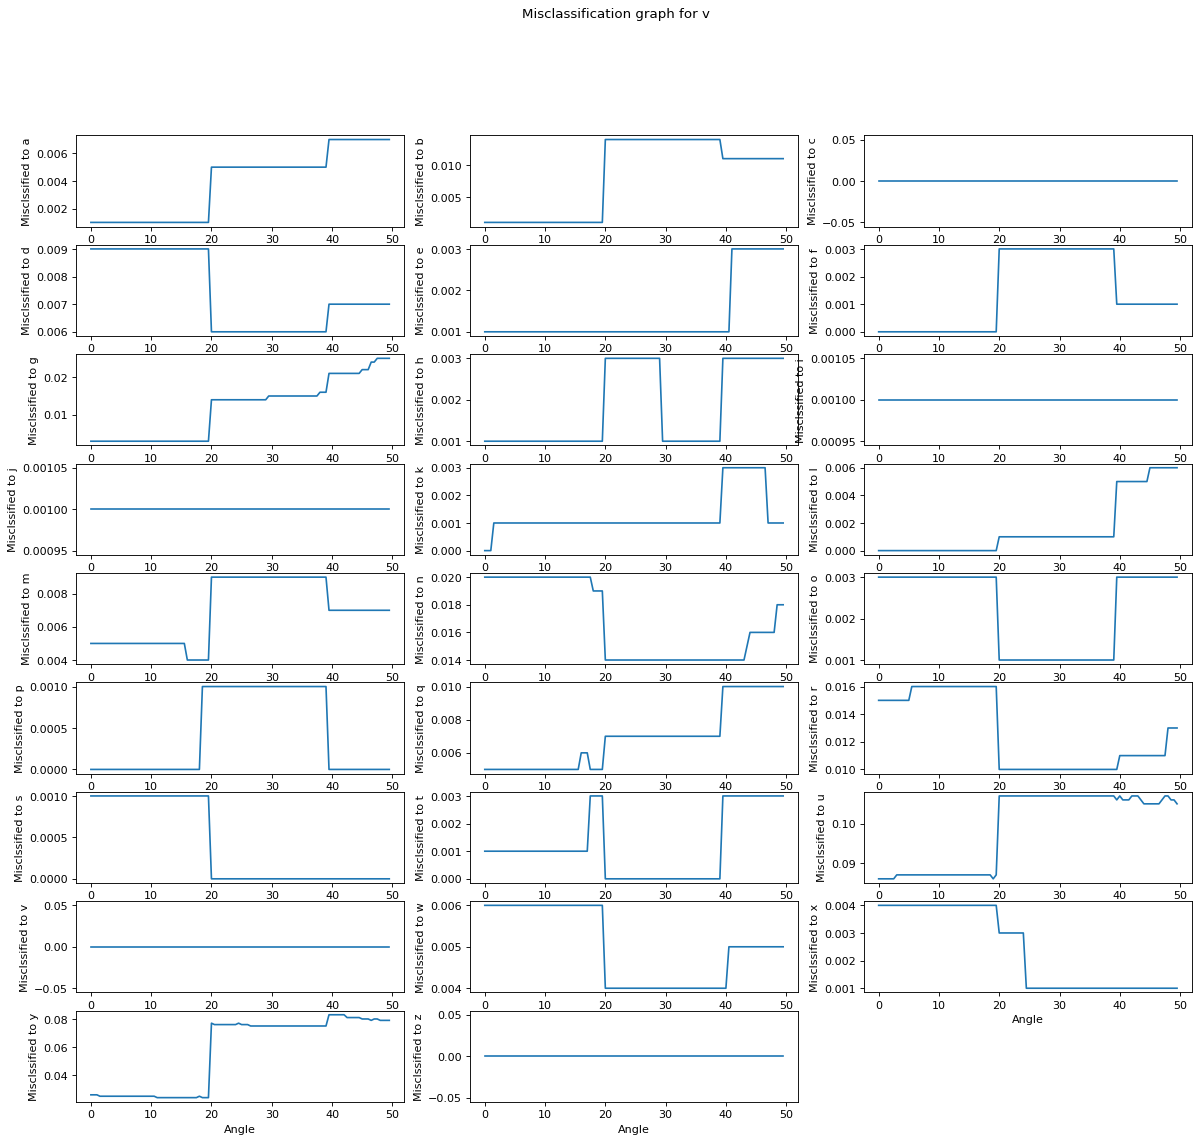

---------------------------------------------------------------------------------------------------------------------


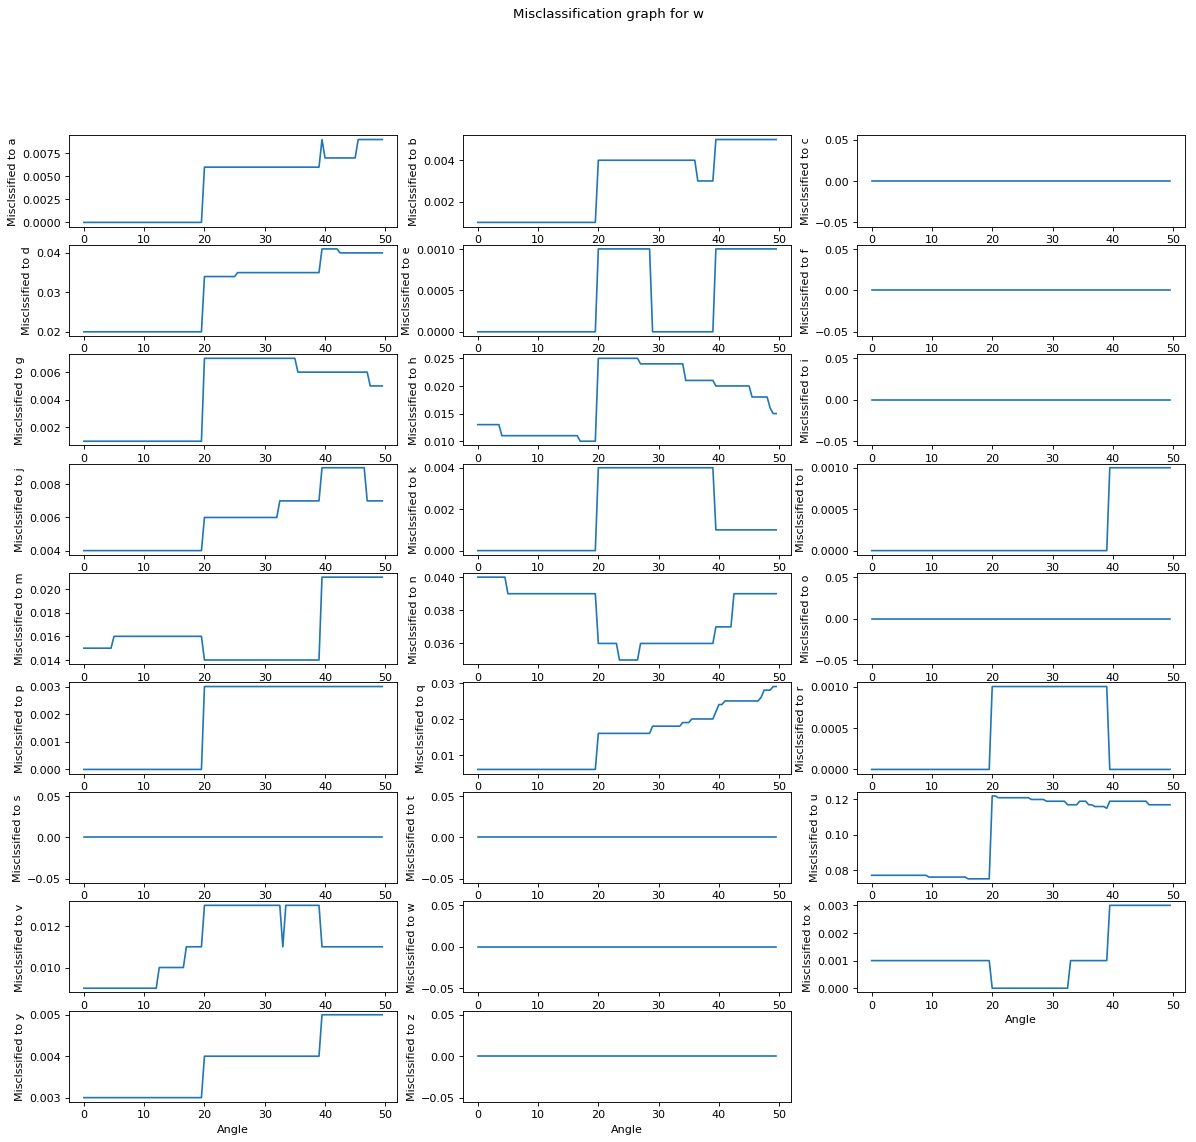

---------------------------------------------------------------------------------------------------------------------


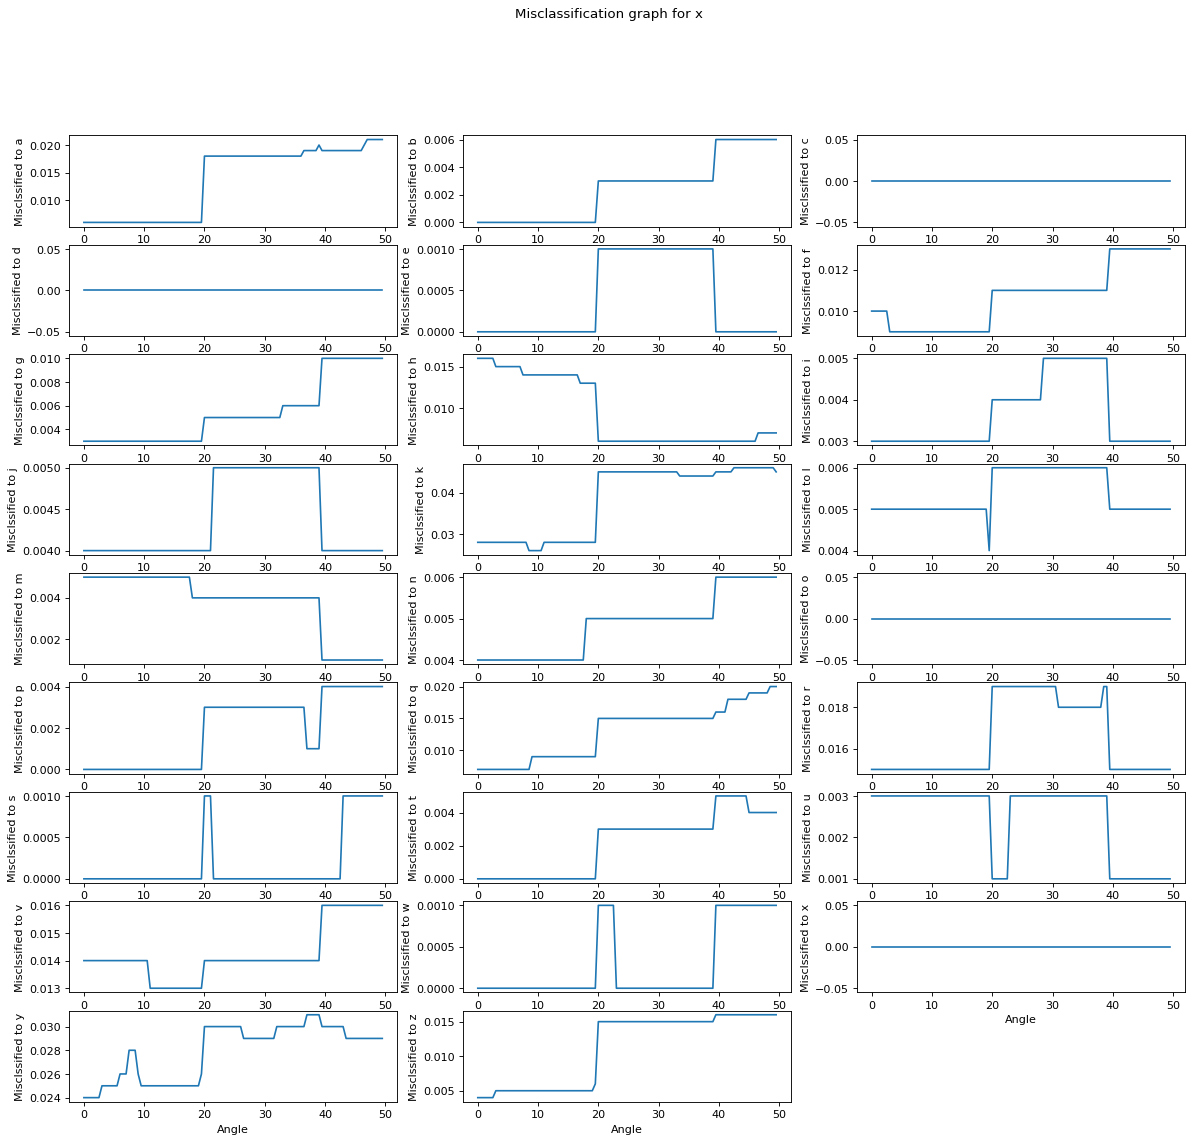

---------------------------------------------------------------------------------------------------------------------


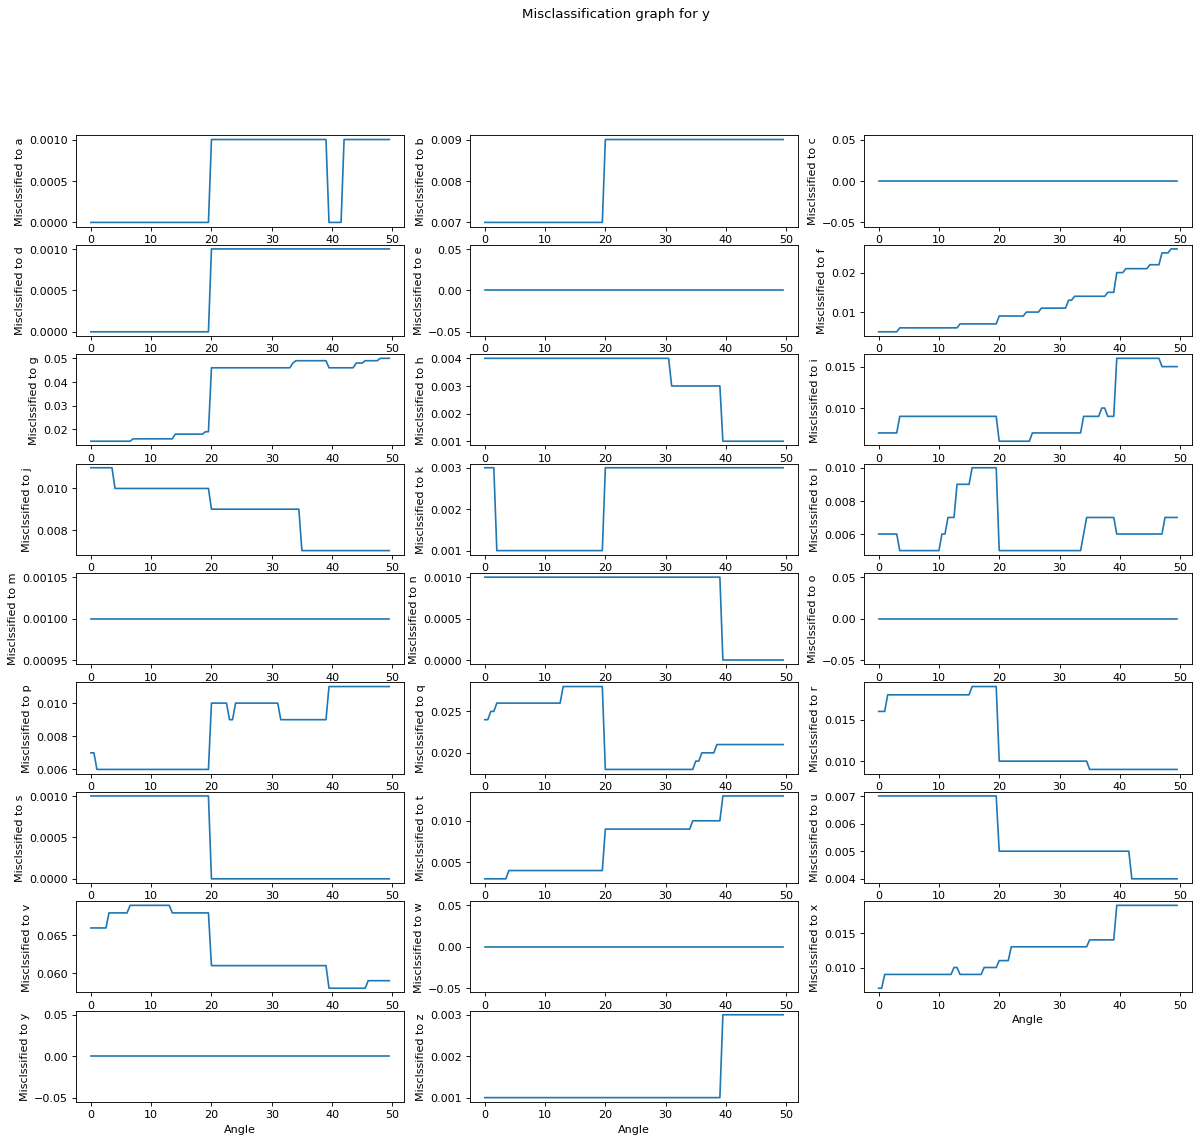

---------------------------------------------------------------------------------------------------------------------


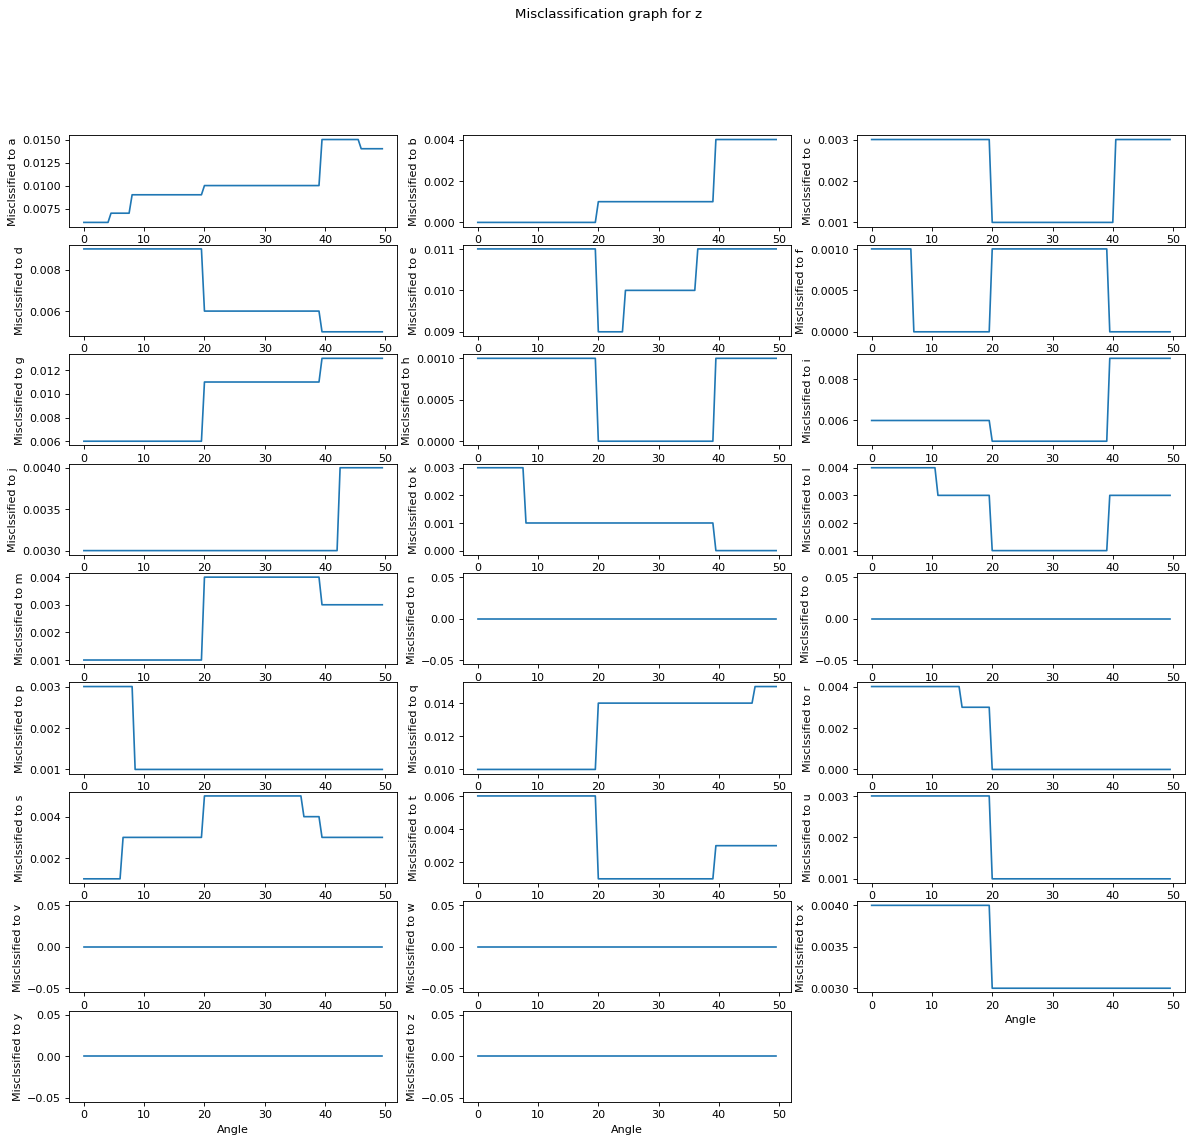

---------------------------------------------------------------------------------------------------------------------


In [131]:
zero = []

for j in range(num_classes):
    figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    for k in range(0,num_classes):
        zero = []
        if j != k: 
            for i in range(len(aMatrix)):
                zero.append(aMatrix[i][j][k])
        else:
            zero+=eps*[0]       
        plt.subplot(9,3,k+1)
        plt.plot(np.arange(0,50,0.5),zero)
        plt.xlabel("Angle")
        plt.ylabel("Misclssified to %s" %chr(97+k))
    plt.suptitle("Misclassification graph for %s" %(chr(97+j)))
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------")

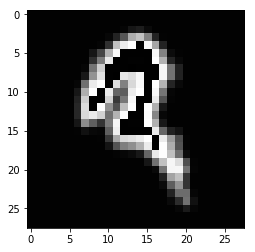

In [132]:
plt.imshow(np.reshape(X_test[0], [28, 28]), cmap='gray')
plt.show()

In [133]:
print(X_test[0])

[[[0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099    ]
  [0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099    ]
  [0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.02166471 0.08833137 0.11578237 0.04127255 0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099     0.0099     0.0099     0.0099    ]
  [0.0099     0.0099     0.0099     0.0099     0.0099     0.0099
   0.0099  